# IRT Psychometric Analysis of Russian Author Recognition Test (ART)

This notebook performs a comprehensive Item Response Theory (IRT) analysis of the ART pretest data.

**Goal**: Build a psychometrically sound latent-trait model of ART responses using 2PL IRT,
understand item behavior, and prepare clean latent ability scores (θ) for validation.

**Dataset**: ~1,835 participants, 205 ART items (real authors + foils) — cleaned via `scripts/data_prep/art_data_prep.ipynb`

---

## Section 0: Setup and Configuration

Import libraries, set paths, and create helper functions for saving outputs.

In [1]:
# ============================================================
# IMPORTS
# ============================================================
import pandas as pd
import numpy as np
from pathlib import Path
import warnings
from datetime import datetime
import importlib

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistics
from scipy import stats
from scipy.special import expit  # logistic function

# Factor Analysis
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo

# Compatibility shim for scikit-learn check_array signature changes (factor_analyzer uses force_all_finite; older sklearn uses ensure_all_finite)
import inspect
from sklearn.utils import validation as _sk_validation

# If the stored "original" is actually our wrapper (e.g. cell run twice), reload to get the real one
if hasattr(_sk_validation, "_cursor_orig_check_array") and getattr(_sk_validation._cursor_orig_check_array, "__name__", "") == "_check_array_compat":
    _sk_validation = importlib.reload(_sk_validation)

import factor_analyzer.factor_analyzer as _fa_internal

# Store the real check_array only once; never overwrite with a wrapper
if not hasattr(_sk_validation, "_cursor_orig_check_array"):
    _sk_validation._cursor_orig_check_array = _sk_validation.check_array

# Use the stored original by attribute lookup inside the wrapper to avoid recursion (no closure over a possibly-stale reference)
_real_check_array = _sk_validation._cursor_orig_check_array
if "force_all_finite" not in inspect.signature(_real_check_array).parameters:
    def _check_array_compat(*args, **kwargs):
        if "force_all_finite" in kwargs:
            kwargs["ensure_all_finite"] = kwargs.pop("force_all_finite")
        return _sk_validation._cursor_orig_check_array(*args, **kwargs)

    _sk_validation.check_array = _check_array_compat
    _fa_internal.check_array = _check_array_compat

# IRT (girth library)
import girth
from girth import twopl_mml
from girth.synthetic import create_synthetic_irt_dichotomous

# Progress bars
from tqdm import tqdm

# Pretty tables
from tabulate import tabulate

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

print("All libraries imported successfully!")
print(f"Analysis started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

All libraries imported successfully!
Analysis started: 2026-02-16 16:30:00


In [2]:
# ============================================================
# CONFIGURATION
# ============================================================

# Random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Project paths
PROJECT_ROOT = Path("../..")
DATA_DIR = PROJECT_ROOT / "data" / "raw"
RESULTS_DIR = PROJECT_ROOT / "results"

# Input: cleaned data from scripts/data_prep/art_data_prep.ipynb
PROCESSED_DIR = PROJECT_ROOT / "data" / "processed" / "art_cleaned"
ART_CSV = PROCESSED_DIR / "ART_pretest_merged_EN_cleaned.csv"
ITEM_METADATA_CSV = PROCESSED_DIR / "item_metadata.csv"
DATA_DIR = PROJECT_ROOT / "data" / "raw"
REAL_AUTHORS_FILE = DATA_DIR / "author_lists" / "real_authors.xls"
FOILS_FILE = DATA_DIR / "author_lists" / "not_real_authors.xls"

# Output directories (already created)
OUTPUT_DIRS = {
    'step0': RESULTS_DIR / 'step0_data_prep',
    'step1': RESULTS_DIR / 'step1_item_descriptives',
    'step2': RESULTS_DIR / 'step2_dimensionality',
    'step3': RESULTS_DIR / 'step3_irt_model',
    'step4': RESULTS_DIR / 'step4_item_analysis',
    'step5': RESULTS_DIR / 'step5_diagnostics',
    'step6': RESULTS_DIR / 'step6_theta_scores',
    'step7': RESULTS_DIR / 'step7_scoring_comparison',
    'step8': RESULTS_DIR / 'step8_short_scale',
    'step9': RESULTS_DIR / 'step9_report'
}

# Plot settings
PLOT_DPI = 300
FIGSIZE_SMALL = (8, 6)
FIGSIZE_MEDIUM = (12, 8)
FIGSIZE_LARGE = (16, 12)

# IRT thresholds
ENDORSEMENT_LOW_THRESHOLD = 0.05   # 5% - floor effect
ENDORSEMENT_HIGH_THRESHOLD = 0.95  # 95% - ceiling effect
DISCRIMINATION_LOW_THRESHOLD = 0.5  # weak discrimination
DIFFICULTY_EXTREME_THRESHOLD = 3.0  # extreme difficulty

print("Configuration loaded:")
print(f"  - Random seed: {RANDOM_SEED}")
print(f"  - Project root: {PROJECT_ROOT.resolve()}")
print(f"  - Results directory: {RESULTS_DIR.resolve()}")

Configuration loaded:
  - Random seed: 42
  - Project root: /home/polina/Documents/Cursor_Projects/Russian Author Recognition Test Cursor
  - Results directory: /home/polina/Documents/Cursor_Projects/Russian Author Recognition Test Cursor/results


### Load cleaned data

**Prerequisite:** Run `scripts/data_prep/art_data_prep.ipynb` first to produce cleaned data in `data/processed/art_cleaned/`.

In [3]:
# ============================================================
# LOAD CLEANED DATA
# ============================================================
raw_df = pd.read_csv(ART_CSV, header=None)
labels_row = raw_df.iloc[0].tolist()
codes_row = raw_df.iloc[1].tolist()
data_df = raw_df.iloc[2:].reset_index(drop=True)
data_df.columns = labels_row

n_demographics = 5
item_labels = labels_row[n_demographics:-1]
item_codes = codes_row[n_demographics:-1]
item_data = data_df[item_labels].copy()
source_col = data_df.iloc[:, -1].reset_index(drop=True)
participant_ids = pd.Index(range(1, len(data_df) + 1), name="participant_id")

# Load item metadata (real/foil classification from data_prep)
item_classification = pd.read_csv(ITEM_METADATA_CSV)
real_author_indices = item_classification[item_classification["is_real_author"]]["item_index"].tolist()
foil_indices = item_classification[item_classification["is_foil"]]["item_index"].tolist()
real_author_names = item_classification[item_classification["is_real_author"]]["item_label"].tolist()
foil_names = item_classification[item_classification["is_foil"]]["item_label"].tolist()

print(f"Loaded: {ART_CSV.name}")
print(f"   Participants: {len(data_df)}, Items: {len(item_labels)}")
print(f"   Real authors: {len(real_author_indices)}, Foils: {len(foil_indices)}")

Saved: ART_pretest_merged_EN.csv (1837 rows x 220 cols)
Saved: real_authors.csv (100 rows)
Saved: not_real_authors.csv (107 rows)
All Excel files converted to CSV.


## Section 1: Data Loading (moved to data_prep)

Data loading, classification, and diagnostics are in `scripts/data_prep/art_data_prep.ipynb`.
The cell above loads the cleaned output. The cells below are no-ops (kept for reference).

In [4]:
# Moved to data_prep. Load cleaned cell above provides all variables.
pass


STEP 0: DATA LOADING AND PREPROCESSING

1. Loading ART pretest dataset...
   Raw data shape: 1837 rows x 220 columns
   Labels extracted: 220 columns
   Data rows: 1835 participants

   First 5 column labels: ['Submited', 'age', 'sex ', 'humanities or not', 'education and profession']
   Last 5 column labels: ['Ilya Ilf', 'Lyudmila Ulitskaya', 'Alexander Tvardovsky', 'Ian Fleming', 'source']


In [5]:
# Moved to data_prep.
pass


2. Loading author reference lists...
   Real authors file shape: (100, 2)
   Foils file shape: (107, 2)

   Sample real authors:
             NaN real
 Khaled Hosseini  139
     Donna Tartt  284
Archibald Cronin  131
   Gillian Flynn  150

   Sample foils:
                  NaN not_real
Геррит ХугенбуM fill1        7
 Гонсало Хервас fill2       15
   Ричард Гоулд fill3       61
  Брайан Каллис fill4       13


In [6]:
# Moved to data_prep.
pass


3. Identifying real authors vs foils in dataset columns...
   Real authors in reference: 99
   Foils in reference: 106
   Expected item columns: 214

   Sample item labels: ['Gerrit HoogenbuM fill1', 'Khaled Hosseini', 'Donna Tartt', 'Gonzalo Hervas fill2', 'Archibald Cronin']
   Sample item codes: ['fill1', 'mod1', 'mod2', 'fill2', 'cla1']


### Diagnostics (moved to data_prep)

See `scripts/data_prep/art_data_prep.ipynb` and `docs/art_cleaning/CLEANING_DECISIONS.md`.

In [8]:
# Moved to data_prep.
pass


 DETAILED DATA EXPLORATION — Pre-Cleaning Diagnostics
 Raw shape: 1835 participants × 220 columns
 Item columns: 214  (+ 5 demographic + 1 source)

──────────────────────────────────────────────────────────────────────
 (a) DEMOGRAPHICS OVERVIEW
──────────────────────────────────────────────────────────────────────

 Columns: ['Submited', 'age', 'sex ', 'humanities or not', 'education and profession']

  ▸ [0] 'Submited'  (dtype=str)
    missing=0 (0.0%), blank strings=0, unique=953
    sample values: ['02/05/2020 9:15', '02/05/2020 8:25', '02/05/2020 8:19', '02/05/2020 7:49', '02/05/2020 7:19']
    dates parsed: 486, range 2020-01-02 → 2020-05-02
  ▸ [1] 'age'  (dtype=str)
    missing=0 (0.0%), blank strings=0, unique=52
    sample values: ['26', '22', '27', '30', '17']
    numeric: 1835 valid, 0 non-numeric → range 1–65, mean 27.8, median 27
  ▸ [2] 'sex '  (dtype=str)
    missing=0 (0.0%), blank strings=0, unique=2
                                                  F:  1264 (68.9%)
 

In [ ]:
# Moved to data_prep.
pass



4. Classifying items as real authors or foils...
   Foil codes extracted from reference: 101
   Sample foil codes: ['fill1', 'fill10', 'fill100', 'fill101', 'fill102']

   Real author items found: 106
   Foil items found: 108
   Unclassified items: 0

   Classification summary:
is_real_author    106
is_foil           108
dtype: int64


In [ ]:
# ============================================================
# HELPER FUNCTIONS
# ============================================================

def save_table(df, step, filename, index=True):
    """Save DataFrame to CSV in the appropriate step's tables folder."""
    output_path = OUTPUT_DIRS[step] / 'tables' / filename
    df.to_csv(output_path, index=index)
    print(f"  Saved table: {output_path.name}")
    return output_path

def save_plot(fig, step, filename, silent=False):
    """Save figure to PNG in the appropriate step's plots folder."""
    output_path = OUTPUT_DIRS[step] / 'plots' / filename
    fig.savefig(output_path, dpi=PLOT_DPI, bbox_inches='tight', facecolor='white')
    plt.close(fig)
    if not silent:
        print(f"  Saved plot: {output_path.name}")
    return output_path

def print_section_header(title):
    """Print a formatted section header."""
    print("\n" + "="*70)
    print(f" {title}")
    print("="*70)

def print_stats_box(title, stats_dict):
    """Print statistics in a formatted box."""
    print(f"\n┌{'─'*50}┐")
    print(f"│ {title:<48} │")
    print(f"├{'─'*50}┤")
    for key, value in stats_dict.items():
        if isinstance(value, float):
            print(f"│ {key:<30} {value:>17.4f} │")
        else:
            print(f"│ {key:<30} {str(value):>17} │")
    print(f"└{'─'*50}┘")

def describe_distribution(data, name="Variable"):
    """Print descriptive statistics for a distribution."""
    stats_dict = {
        'N': len(data),
        'Mean': np.mean(data),
        'Std Dev': np.std(data),
        'Min': np.min(data),
        'Q1 (25%)': np.percentile(data, 25),
        'Median': np.median(data),
        'Q3 (75%)': np.percentile(data, 75),
        'Max': np.max(data)
    }
    print_stats_box(f"{name} Distribution", stats_dict)

# Set global plot style (handle different matplotlib versions)
try:
    plt.style.use('seaborn-v0_8-whitegrid')
except OSError:
    try:
        plt.style.use('seaborn-whitegrid')
    except OSError:
        plt.style.use('ggplot')  # Fallback

sns.set_palette('colorblind')
plt.rcParams['figure.figsize'] = FIGSIZE_MEDIUM
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

print("Helper functions defined and plot style configured.")

Helper functions defined and plot style configured.


In [ ]:
# ============================================================
# DATA CLEANING: HANDLE MISSING DATA AND CONVERT TO BINARY
# ============================================================

print("\n6. Cleaning data and converting to binary format...")

# --- BEGIN: Define or recover item_data from loaded DataFrame ---
# Try to recover item_data from obvious previous dataframes, else raise informative error

def _resolve_item_data():
    """Safely attempts to find item_data DataFrame in global namespace."""
    candidates = ['item_data', 'responses', 'resp_df', 'df_items']
    g = globals()
    for name in candidates:
        if name in g and g[name] is not None:
            # Ensure it's a DataFrame-like object by checking for .isnull()
            obj = g[name]
            if hasattr(obj, "isnull") and callable(getattr(obj, "isnull")):
                return obj
    return None

item_data = _resolve_item_data()
if item_data is None:
    raise NameError(
        "item_data is not defined or is None. Please prepare the DataFrame of item responses (e.g., item_data), "
        "with items as columns and participants as rows, before running this cleaning step.\n"
        "If your main DataFrame uses a different variable name, assign it to `item_data`."
    )

# Proceed with missing data analysis
try:
    missing_count = item_data.isnull().sum()
    missing_by_row = item_data.isnull().sum(axis=1)

    print(f"\n   Missing data analysis:")
    print(f"   - Columns with any missing: {(missing_count > 0).sum()}")
    print(f"   - Total missing cells: {item_data.isnull().sum().sum()}")
    print(f"   - Participants with any missing: {(missing_by_row > 0).sum()}")

    # Identify columns with high missing rates (e.g., known last 9 items problem)
    missing_pct = missing_count / len(item_data) * 100
    high_missing_cols = missing_pct[missing_pct > 40].sort_values(ascending=False)

    if len(high_missing_cols) > 0:
        print(f"\n   Columns with >40% missing data ({len(high_missing_cols)} items):")
        for col, pct in high_missing_cols.head(10).items():
            print(f"      {col}: {pct:.1f}% missing")
except Exception as e:
    print(f"  [Error during missing data analysis: {e}]")
    raise

# Convert responses to binary (0/1)
def convert_to_binary(val):
    """Convert response to binary: 1 if checked, 0 otherwise."""
    if pd.isna(val):
        return 0
    try:
        return 1 if float(val) == 1 else 0
    except (ValueError, TypeError):
        return 0

# Apply binary conversion (prefer .map for pandas >=2.1, fallback to .applymap)
try:
    item_data_binary = item_data.map(convert_to_binary)
except Exception as ex:
    item_data_binary = item_data.applymap(convert_to_binary)

print(f"\n   Binary conversion complete.")
print(f"   Response matrix shape: {item_data_binary.shape}")
print(f"   Value counts in first column: {item_data_binary.iloc[:, 0].value_counts().to_dict()}")


6. Cleaning data and converting to binary format...

   Missing data analysis:
   - Columns with any missing: 19
   - Total missing cells: 13396
   - Participants with any missing: 1835

   Columns with >40% missing data (10 items):
      Ian Fleming: 99.9% missing
      Ian Fleming: 99.9% missing
      Sergey Nikitin fill 103: 87.5% missing
      Alexander Tvardovsky: 68.1% missing
      Ilya Ilf: 68.1% missing
      Lyudmila Ulitskaya: 68.1% missing
      Vladimir Gusakov fill 101: 43.6% missing
      Chabo Chucky fill 105: 43.6% missing
      Ivan Savin fill 102: 43.6% missing
      Evgenia Serova fill 104: 43.6% missing

   Binary conversion complete.
   Response matrix shape: (1835, 216)
   Value counts in first column: {0: 1819, 1: 16}


In [ ]:
# ============================================================
# EXCLUDE HIGH-MISSING ITEMS FROM FURTHER ANALYSIS
# ============================================================
MISSING_EXCLUDE_PCT = 40  # Exclude items with >40% missing

missing_pct = item_data.isnull().sum() / len(item_data) * 100
high_missing = missing_pct[missing_pct > MISSING_EXCLUDE_PCT].sort_values(ascending=False)
excluded_set = set(high_missing.index)

# Drop every column whose name is in the excluded set (handles duplicate column names)
cols_to_drop = [c for c in item_data_binary.columns if c in excluded_set]
n_dropped = len(cols_to_drop)

if n_dropped > 0:
    item_data_binary = item_data_binary.drop(columns=cols_to_drop)
    item_data = item_data.drop(columns=cols_to_drop)
    # Keep item_labels and item_codes in sync (same order as remaining columns)
    indices_keep = [i for i, lab in enumerate(item_labels) if lab not in excluded_set]
    item_labels = [item_labels[i] for i in indices_keep]
    item_codes = [item_codes[i] for i in indices_keep]
    # Rebuild author/foil index lists by name (remaining items only)
    real_author_indices = [i for i, lab in enumerate(item_labels) if lab in set(real_author_names)]
    foil_indices = [i for i, lab in enumerate(item_labels) if lab in set(foil_names)]
    # Update classification table to remaining items only
    item_classification = item_classification[~item_classification["item_label"].isin(excluded_set)].reset_index(drop=True)
    item_classification["item_index"] = range(len(item_classification))

    print(f"\n   Excluded {n_dropped} items with >{MISSING_EXCLUDE_PCT}% missing from further analysis:")
    for col, pct in high_missing.items():
        print(f"      {col}: {pct:.1f}% missing")
    print(f"\n   Response matrix after exclusion: {item_data_binary.shape[0]} participants x {item_data_binary.shape[1]} items")
    print(f"   Real author items: {len(real_author_indices)}, Foil items: {len(foil_indices)}")
else:
    print(f"\n   No items above {MISSING_EXCLUDE_PCT}% missing; none excluded.")


   Excluded 12 items with >40% missing from further analysis:
      Ian Fleming: 99.9% missing
      Ian Fleming: 99.9% missing
      Sergey Nikitin fill 103: 87.5% missing
      Alexander Tvardovsky: 68.1% missing
      Ilya Ilf: 68.1% missing
      Lyudmila Ulitskaya: 68.1% missing
      Vladimir Gusakov fill 101: 43.6% missing
      Chabo Chucky fill 105: 43.6% missing
      Ivan Savin fill 102: 43.6% missing
      Evgenia Serova fill 104: 43.6% missing

   Response matrix after exclusion: 1835 participants x 204 items
   Real author items: 101, Foil items: 103


In [ ]:
# ============================================================
# SEPARATE REAL AUTHORS AND FOILS INTO MATRICES
# ============================================================
print("\n7. Creating separate response matrices...")

# Extract real author columns
real_author_cols = [item_labels[i] for i in real_author_indices]
author_response_matrix = item_data_binary[real_author_cols].copy()
author_response_matrix.index = participant_ids

# Extract foil columns
foil_cols = [item_labels[i] for i in foil_indices]
foil_response_matrix = item_data_binary[foil_cols].copy()
foil_response_matrix.index = participant_ids

print(f"   Author response matrix: {author_response_matrix.shape[0]} participants x {author_response_matrix.shape[1]} authors")
print(f"   Foil response matrix: {foil_response_matrix.shape[0]} participants x {foil_response_matrix.shape[1]} foils")

# Calculate foil error rate for each participant
foil_count = foil_response_matrix.sum(axis=1)
total_foils = foil_response_matrix.shape[1]
error_rate = foil_count / total_foils

print(f"\n   Foil error rate statistics:")
describe_distribution(error_rate.values, "Error Rate")


7. Creating separate response matrices...
   Author response matrix: 1835 participants x 101 authors
   Foil response matrix: 1835 participants x 103 foils

   Foil error rate statistics:

┌──────────────────────────────────────────────────┐
│ Error Rate Distribution                          │
├──────────────────────────────────────────────────┤
│ N                                           1835 │
│ Mean                                      0.0839 │
│ Std Dev                                   0.0882 │
│ Min                                       0.0000 │
│ Q1 (25%)                                  0.0194 │
│ Median                                    0.0583 │
│ Q3 (75%)                                  0.1359 │
│ Max                                       0.7184 │
└──────────────────────────────────────────────────┘


In [ ]:
# ============================================================
# CREATE PARTICIPANT SUMMARY
# ============================================================
print("\n8. Creating participant summary...")

# Calculate classical scores for each participant
hits = author_response_matrix.sum(axis=1)  # Number of real authors endorsed
false_alarms = foil_response_matrix.sum(axis=1)  # Number of foils endorsed
classical_score = hits - false_alarms  # Traditional ART score: hits - false alarms

# Create participant summary DataFrame
participant_summary = pd.DataFrame({
    'participant_id': participant_ids,
    'source': source_col.values,
    'n_authors_endorsed': hits.values,
    'n_foils_endorsed': false_alarms.values,
    'classical_score': classical_score.values,
    'error_rate': error_rate.values,
    'total_endorsements': (hits + false_alarms).values
})

print(f"   Participant summary created with {len(participant_summary)} rows")

# Display summary statistics
print_stats_box("Classical Score Statistics", {
    'N': len(classical_score),
    'Mean': classical_score.mean(),
    'Std Dev': classical_score.std(),
    'Min': classical_score.min(),
    'Max': classical_score.max(),
    'Range': classical_score.max() - classical_score.min()
})

# Show score distribution by source
print("\n   Scores by data source:")
print(participant_summary.groupby('source')[['classical_score', 'error_rate']].agg(['mean', 'std', 'count']).round(3))


8. Creating participant summary...
   Participant summary created with 1835 rows

┌──────────────────────────────────────────────────┐
│ Classical Score Statistics                       │
├──────────────────────────────────────────────────┤
│ N                                           1835 │
│ Mean                                     38.4349 │
│ Std Dev                                  20.5227 │
│ Min                                           -8 │
│ Max                                           98 │
│ Range                                        106 │
└──────────────────────────────────────────────────┘

   Scores by data source:
                       classical_score               error_rate             
                                  mean     std count       mean    std count
source                                                                      
ART_prestest_responses          27.411  13.086   800      0.136  0.081   800
pretest_EN                      46.956  21.167  1035


9. Creating Step 0 visualizations...


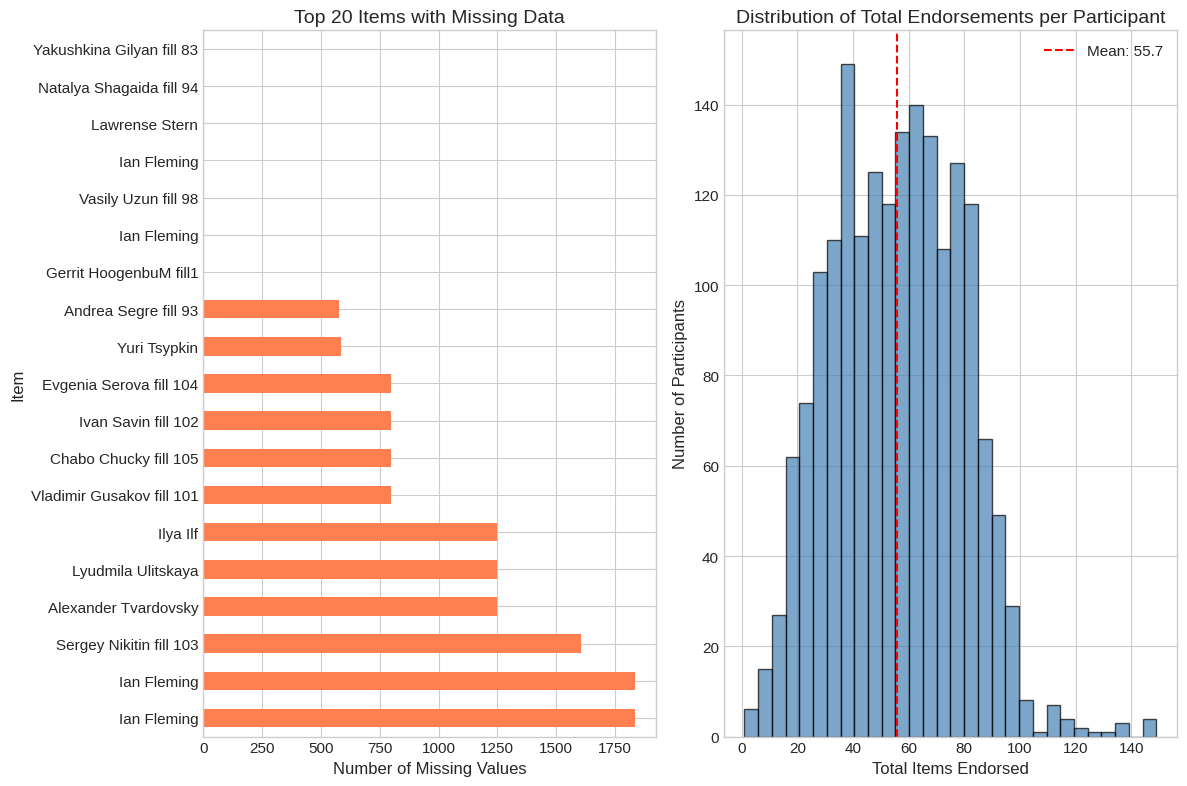

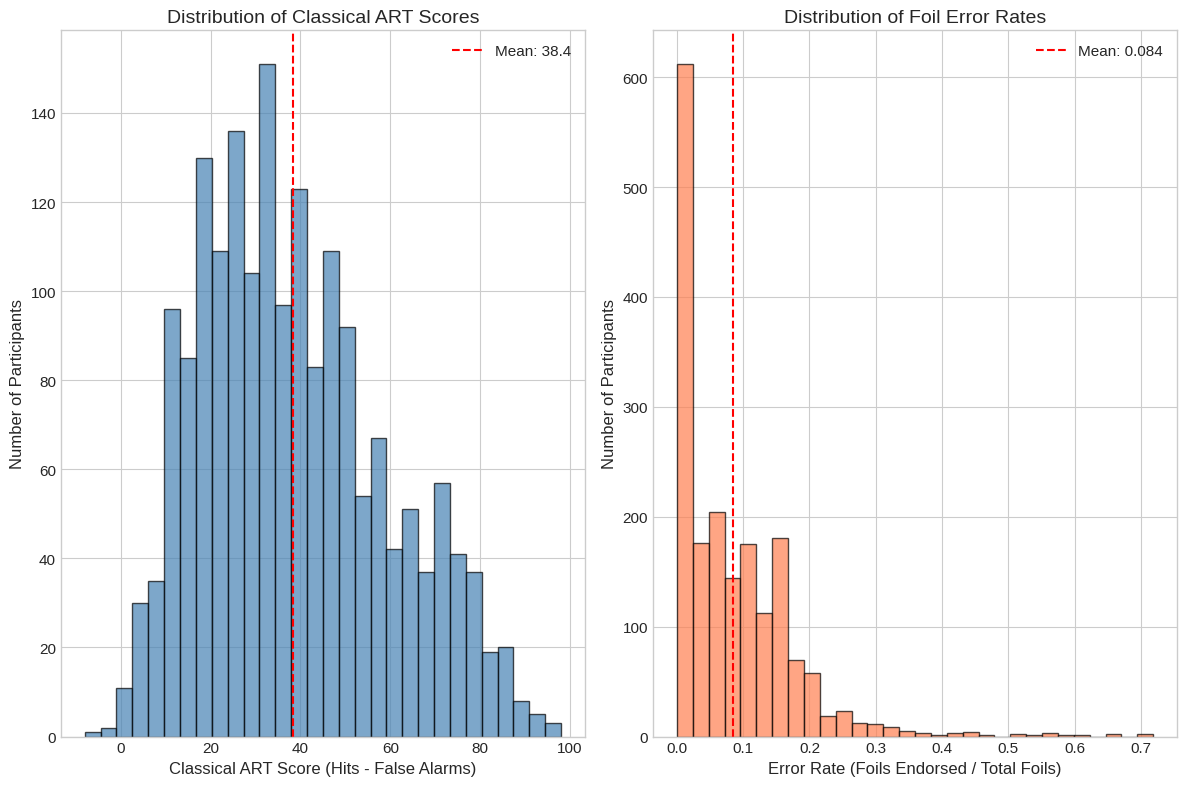

  Saved step0 plots: missing_data_and_response_distribution.png, response_distribution.png


In [ ]:
# ============================================================
# STEP 0 VISUALIZATIONS
# ============================================================
print("\n9. Creating Step 0 visualizations...")

# Plot 1: Missing data heatmap (sample of columns with missing data)
fig, axes = plt.subplots(1, 2, figsize=FIGSIZE_MEDIUM)

# Missing data by column
ax1 = axes[0]
cols_with_missing = missing_count[missing_count > 0].sort_values(ascending=False)
if len(cols_with_missing) > 0:
    cols_with_missing.head(20).plot(kind='barh', ax=ax1, color='coral')
    ax1.set_xlabel('Number of Missing Values')
    ax1.set_ylabel('Item')
    ax1.set_title('Top 20 Items with Missing Data')
else:
    ax1.text(0.5, 0.5, 'No missing data', ha='center', va='center', transform=ax1.transAxes)
    ax1.set_title('Missing Data Analysis')

# Response distribution
ax2 = axes[1]
total_endorsements = item_data_binary.sum(axis=1)
ax2.hist(total_endorsements, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
ax2.axvline(total_endorsements.mean(), color='red', linestyle='--', label=f'Mean: {total_endorsements.mean():.1f}')
ax2.set_xlabel('Total Items Endorsed')
ax2.set_ylabel('Number of Participants')
ax2.set_title('Distribution of Total Endorsements per Participant')
ax2.legend()

plt.tight_layout()
plt.show()  # Display in notebook before saving (save_plot closes the figure)
save_plot(fig, 'step0', 'missing_data_and_response_distribution.png', silent=True)

# Plot 2: Classical score distribution
fig, axes = plt.subplots(1, 2, figsize=FIGSIZE_MEDIUM)

ax1 = axes[0]
ax1.hist(classical_score, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
ax1.axvline(classical_score.mean(), color='red', linestyle='--', label=f'Mean: {classical_score.mean():.1f}')
ax1.set_xlabel('Classical ART Score (Hits - False Alarms)')
ax1.set_ylabel('Number of Participants')
ax1.set_title('Distribution of Classical ART Scores')
ax1.legend()

ax2 = axes[1]
ax2.hist(error_rate, bins=30, edgecolor='black', alpha=0.7, color='coral')
ax2.axvline(error_rate.mean(), color='red', linestyle='--', label=f'Mean: {error_rate.mean():.3f}')
ax2.set_xlabel('Error Rate (Foils Endorsed / Total Foils)')
ax2.set_ylabel('Number of Participants')
ax2.set_title('Distribution of Foil Error Rates')
ax2.legend()

plt.tight_layout()
plt.show()  # Display in notebook before saving (save_plot closes the figure)
save_plot(fig, 'step0', 'response_distribution.png', silent=True)
print("  Saved step0 plots: missing_data_and_response_distribution.png, response_distribution.png")

In [ ]:
# ============================================================
# SAVE STEP 0 OUTPUTS
# ============================================================
print("\n10. Saving Step 0 outputs...")

# Save author response matrix
save_table(author_response_matrix, 'step0', 'author_response_matrix.csv')

# Save foil response matrix
save_table(foil_response_matrix, 'step0', 'foil_response_matrix.csv')

# Save participant summary
save_table(participant_summary, 'step0', 'participant_summary.csv', index=False)

# Count participants by source
source_counts = source_col.value_counts().sort_index()

# Create data quality report
data_quality_report = pd.DataFrame({
    'metric': [
        'Total participants',
        'Total items',
        'Real author items',
        'Foil items',
        'Unclassified items',
        'Columns with missing data',
        'Total missing cells',
        'Participants from source 1',
        'Participants from source 2',
        'Mean classical score',
        'Std classical score',
        'Mean error rate',
        'Std error rate'
    ],
    'value': [
        len(participant_ids),
        len(item_labels),
        len(real_author_indices),
        len(foil_indices),
        len(unclassified_indices),
        (missing_count > 0).sum(),
        item_data.isnull().sum().sum(),
        source_counts.iloc[0] if len(source_counts) > 0 else 0,
        source_counts.iloc[1] if len(source_counts) > 1 else 0,
        round(classical_score.mean(), 4),
        round(classical_score.std(), 4),
        round(error_rate.mean(), 4),
        round(error_rate.std(), 4)
    ]
})
save_table(data_quality_report, 'step0', 'data_quality_report.csv', index=False)

print("\n" + "="*70)
print(" STEP 0 COMPLETE: Data loaded and preprocessed")
print("="*70)
print(f"\n Key outputs:")
print(f"   - Author response matrix: {author_response_matrix.shape}")
print(f"   - Foil response matrix: {foil_response_matrix.shape}")
print(f"   - Participant summary: {participant_summary.shape}")


10. Saving Step 0 outputs...
  Saved table: author_response_matrix.csv
  Saved table: foil_response_matrix.csv
  Saved table: participant_summary.csv
  Saved table: data_quality_report.csv

 STEP 0 COMPLETE: Data loaded and preprocessed

 Key outputs:
   - Author response matrix: (1835, 101)
   - Foil response matrix: (1835, 103)
   - Participant summary: (1835, 7)


## Section 2: Item Descriptive Checks (Step 1)

Compute endorsement rates for each author item, identify floor/ceiling effects, and visualize item difficulty distribution.

In [ ]:
# ============================================================
# STEP 1: ITEM DESCRIPTIVE CHECKS
# ============================================================
print_section_header("STEP 1: ITEM DESCRIPTIVE CHECKS")

# Compute endorsement rate for each real author item
# Endorsement rate = % of participants who marked each author
endorsement_rates = author_response_matrix.mean()  # Mean of binary = proportion

print(f"\n1. Computing endorsement rates for {len(endorsement_rates)} author items...")

# Create item statistics table
item_stats = pd.DataFrame({
    'author': endorsement_rates.index,
    'endorsement_rate': endorsement_rates.values,
    'endorsement_pct': endorsement_rates.values * 100,
    'n_endorsed': author_response_matrix.sum().values,
    'n_total': len(author_response_matrix)
})

# Sort by endorsement rate
item_stats = item_stats.sort_values('endorsement_rate', ascending=False).reset_index(drop=True)

# Display distribution statistics
describe_distribution(endorsement_rates.values * 100, "Endorsement Rate (%)")

# Show quintiles
print("\n   Endorsement rate quintiles:")
for q in [0, 20, 40, 60, 80, 100]:
    val = np.percentile(endorsement_rates.values * 100, q)
    print(f"      {q}th percentile: {val:.1f}%")


 STEP 1: ITEM DESCRIPTIVE CHECKS

1. Computing endorsement rates for 101 author items...

┌──────────────────────────────────────────────────┐
│ Endorsement Rate (%) Distribution                │
├──────────────────────────────────────────────────┤
│ N                                            101 │
│ Mean                                     46.6124 │
│ Std Dev                                  24.6187 │
│ Min                                       2.7793 │
│ Q1 (25%)                                 30.1362 │
│ Median                                   43.3787 │
│ Q3 (75%)                                 61.1444 │
│ Max                                      97.3842 │
└──────────────────────────────────────────────────┘

   Endorsement rate quintiles:
      0th percentile: 2.8%
      20th percentile: 27.2%
      40th percentile: 35.6%
      60th percentile: 49.8%
      80th percentile: 67.7%
      100th percentile: 97.4%


In [ ]:
# ============================================================
# FLAG ITEMS WITH FLOOR/CEILING EFFECTS
# ============================================================
print("\n2. Flagging items with floor/ceiling effects...")

# Flag items with very low (<5%) or very high (>95%) endorsement
item_stats['floor_effect'] = item_stats['endorsement_rate'] < ENDORSEMENT_LOW_THRESHOLD
item_stats['ceiling_effect'] = item_stats['endorsement_rate'] > ENDORSEMENT_HIGH_THRESHOLD
item_stats['flagged'] = item_stats['floor_effect'] | item_stats['ceiling_effect']

# Count flagged items
n_floor = item_stats['floor_effect'].sum()
n_ceiling = item_stats['ceiling_effect'].sum()
n_flagged = item_stats['flagged'].sum()

print_stats_box("Item Flagging Summary", {
    'Total items': len(item_stats),
    'Floor effect (<5%)': n_floor,
    'Ceiling effect (>95%)': n_ceiling,
    'Total flagged': n_flagged,
    'Items OK': len(item_stats) - n_flagged,
    'Floor threshold': f"{ENDORSEMENT_LOW_THRESHOLD*100:.0f}%",
    'Ceiling threshold': f"{ENDORSEMENT_HIGH_THRESHOLD*100:.0f}%"
})

# Show flagged items
if n_floor > 0:
    print(f"\n   Items with FLOOR effect (endorsement < {ENDORSEMENT_LOW_THRESHOLD*100:.0f}%):")
    floor_items = item_stats[item_stats['floor_effect']][['author', 'endorsement_pct']].head(10)
    print(tabulate(floor_items, headers='keys', tablefmt='simple', showindex=False, floatfmt='.2f'))

if n_ceiling > 0:
    print(f"\n   Items with CEILING effect (endorsement > {ENDORSEMENT_HIGH_THRESHOLD*100:.0f}%):")
    ceiling_items = item_stats[item_stats['ceiling_effect']][['author', 'endorsement_pct']].head(10)
    print(tabulate(ceiling_items, headers='keys', tablefmt='simple', showindex=False, floatfmt='.2f'))


2. Flagging items with floor/ceiling effects...

┌──────────────────────────────────────────────────┐
│ Item Flagging Summary                            │
├──────────────────────────────────────────────────┤
│ Total items                                  101 │
│ Floor effect (<5%)                             1 │
│ Ceiling effect (>95%)                          7 │
│ Total flagged                                  8 │
│ Items OK                                      93 │
│ Floor threshold                               5% │
│ Ceiling threshold                            95% │
└──────────────────────────────────────────────────┘

   Items with FLOOR effect (endorsement < 5%):
author          endorsement_pct
------------  -----------------
Yuri Tsypkin               2.78

   Items with CEILING effect (endorsement > 95%):
author                endorsement_pct
------------------  -----------------
Jack London                     97.38
Agatha Christie                 97.17
Arthur Conan Doyle  


3. Creating Step 1 visualizations...


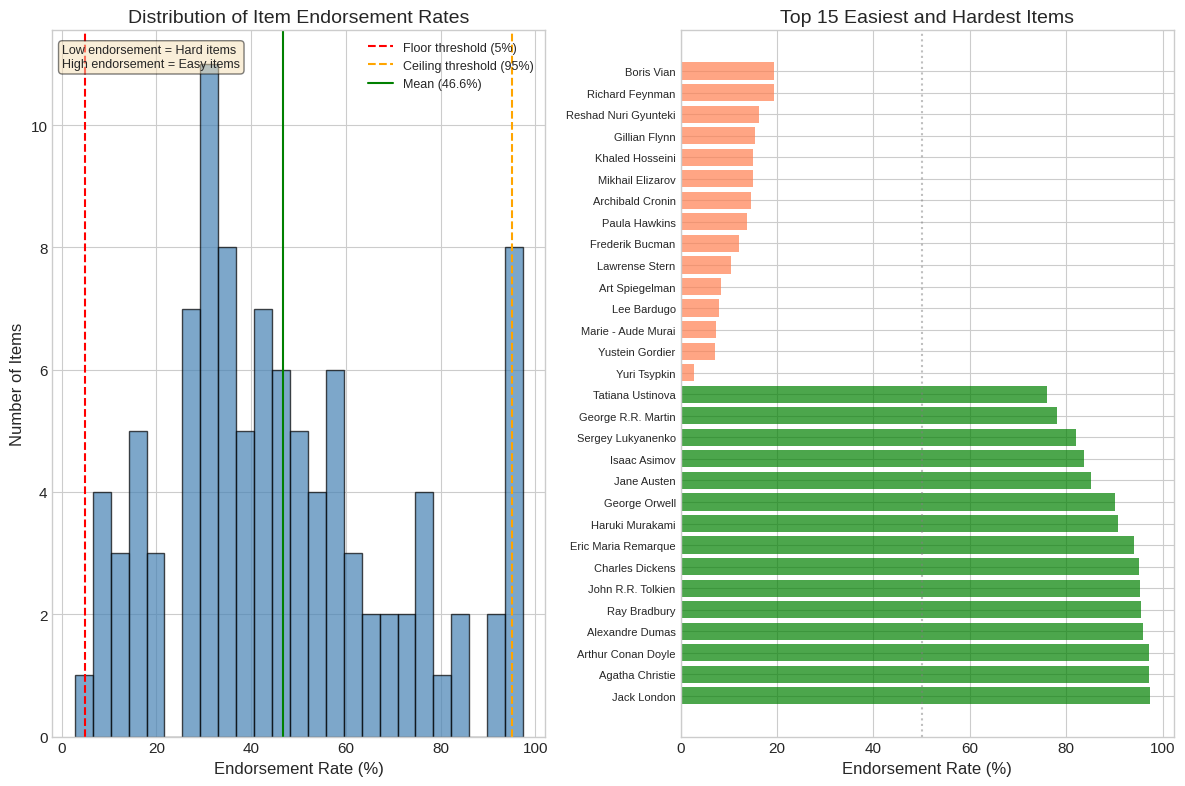

PosixPath('../../results/step1_item_descriptives/plots/endorsement_histogram.png')

In [ ]:
# ============================================================
# STEP 1 VISUALIZATIONS
# ============================================================
print("\n3. Creating Step 1 visualizations...")

# Plot 1: Histogram of endorsement rates
fig, axes = plt.subplots(1, 2, figsize=FIGSIZE_MEDIUM)

ax1 = axes[0]
ax1.hist(endorsement_rates * 100, bins=25, edgecolor='black', alpha=0.7, color='steelblue')
ax1.axvline(ENDORSEMENT_LOW_THRESHOLD * 100, color='red', linestyle='--', 
            label=f'Floor threshold ({ENDORSEMENT_LOW_THRESHOLD*100:.0f}%)')
ax1.axvline(ENDORSEMENT_HIGH_THRESHOLD * 100, color='orange', linestyle='--',
            label=f'Ceiling threshold ({ENDORSEMENT_HIGH_THRESHOLD*100:.0f}%)')
ax1.axvline(endorsement_rates.mean() * 100, color='green', linestyle='-',
            label=f'Mean ({endorsement_rates.mean()*100:.1f}%)')
ax1.set_xlabel('Endorsement Rate (%)')
ax1.set_ylabel('Number of Items')
ax1.set_title('Distribution of Item Endorsement Rates')
ax1.legend(fontsize=9)

# Add difficulty interpretation
ax1.text(0.02, 0.98, 'Low endorsement = Hard items\nHigh endorsement = Easy items',
         transform=ax1.transAxes, fontsize=9, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Plot 2: Sorted bar plot of top/bottom items
ax2 = axes[1]
n_show = 15
# Top 15 easiest items
top_items = item_stats.nlargest(n_show, 'endorsement_rate')
bottom_items = item_stats.nsmallest(n_show, 'endorsement_rate')
combined = pd.concat([top_items, bottom_items])

colors = ['green' if rate > 0.5 else 'coral' for rate in combined['endorsement_rate']]
bars = ax2.barh(range(len(combined)), combined['endorsement_pct'], color=colors, alpha=0.7)
ax2.set_yticks(range(len(combined)))
ax2.set_yticklabels(combined['author'].str[:20], fontsize=8)  # Truncate long names
ax2.set_xlabel('Endorsement Rate (%)')
ax2.set_title(f'Top {n_show} Easiest and Hardest Items')
ax2.axvline(50, color='gray', linestyle=':', alpha=0.5)

plt.tight_layout()
plt.show()  # Display in notebook before saving (save_plot closes the figure)
save_plot(fig, 'step1', 'endorsement_histogram.png', silent=True)

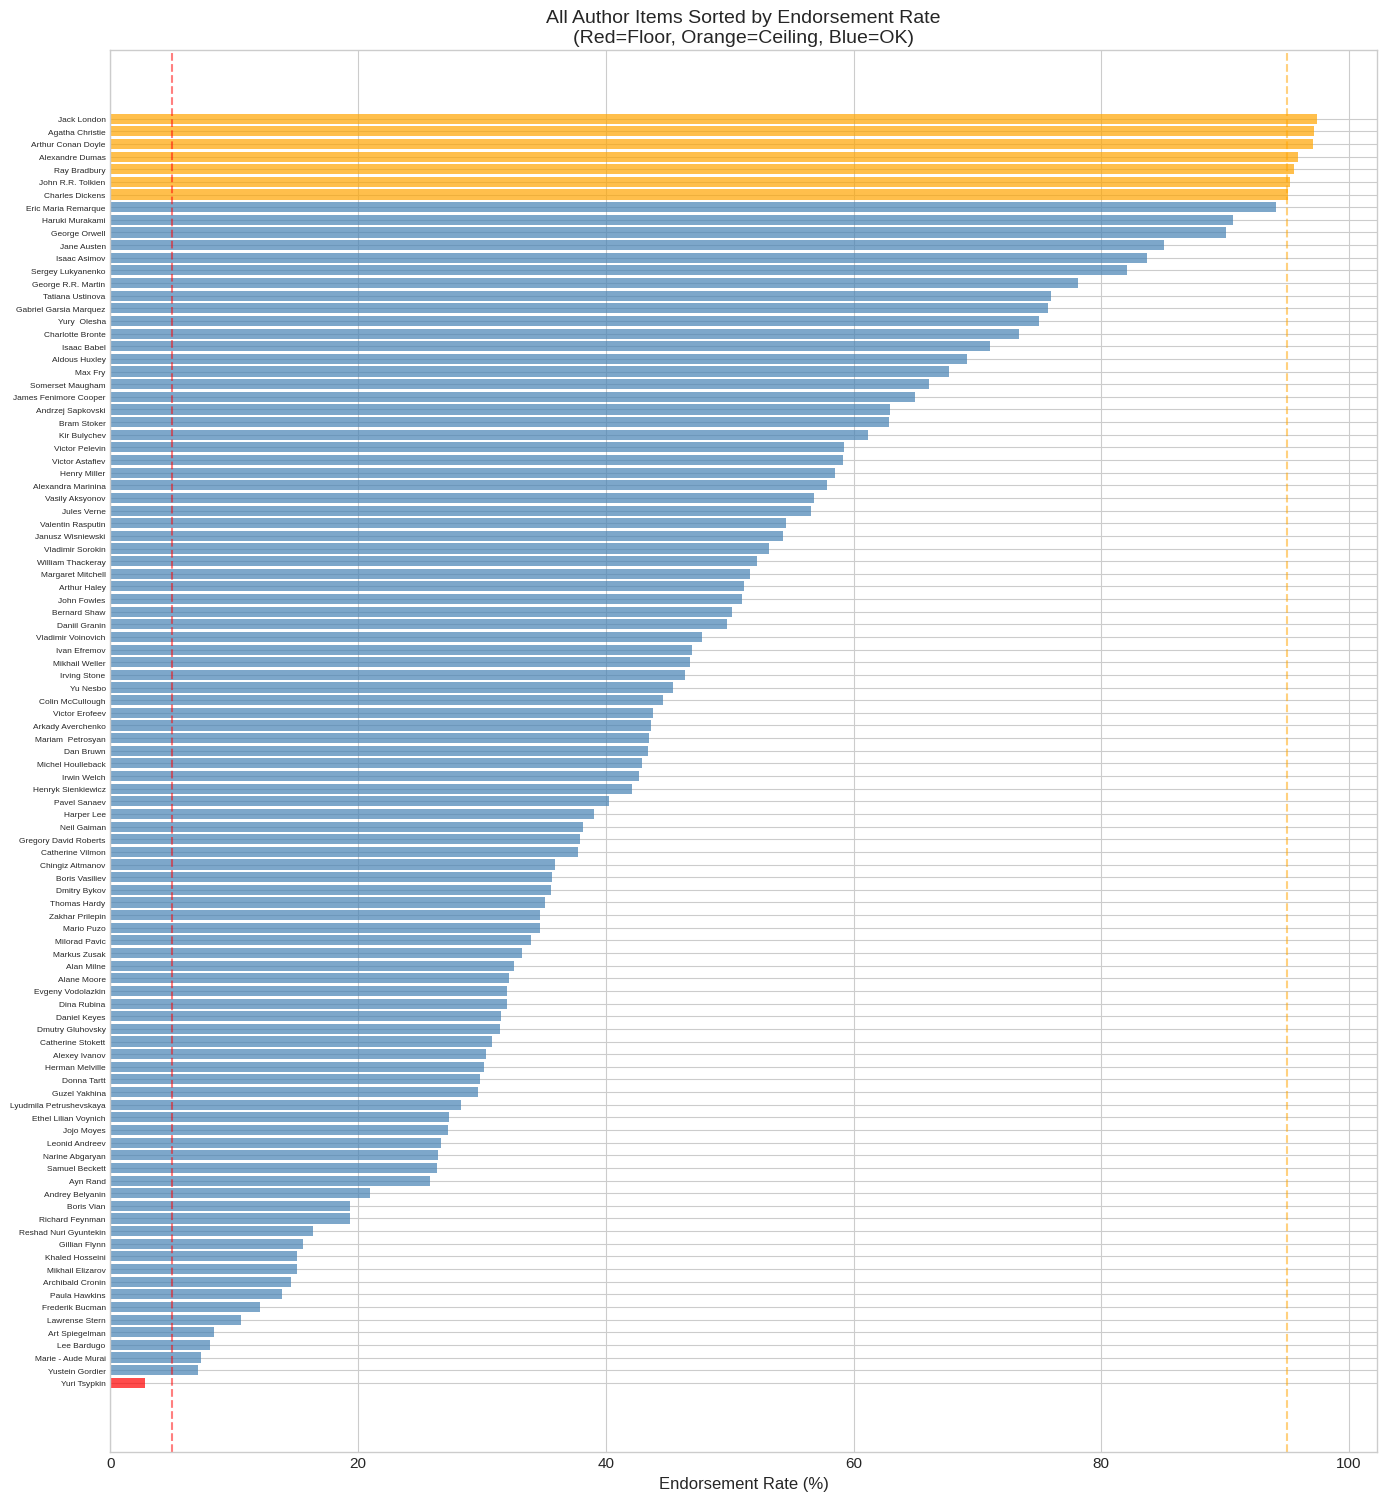

  Saved step1 plots: endorsement_histogram.png, endorsement_by_author.png


In [ ]:
# ============================================================
# ADDITIONAL VISUALIZATION: All items sorted by endorsement
# ============================================================

# Create comprehensive bar plot of all items
fig, ax = plt.subplots(figsize=(14, max(10, len(item_stats) * 0.15)))

# Sort and plot
sorted_stats = item_stats.sort_values('endorsement_rate')
colors = ['red' if row['floor_effect'] else 'orange' if row['ceiling_effect'] else 'steelblue' 
          for _, row in sorted_stats.iterrows()]

ax.barh(range(len(sorted_stats)), sorted_stats['endorsement_pct'], color=colors, alpha=0.7)
ax.set_yticks(range(len(sorted_stats)))
ax.set_yticklabels(sorted_stats['author'].str[:25], fontsize=6)
ax.set_xlabel('Endorsement Rate (%)')
ax.set_title('All Author Items Sorted by Endorsement Rate\n(Red=Floor, Orange=Ceiling, Blue=OK)')
ax.axvline(ENDORSEMENT_LOW_THRESHOLD * 100, color='red', linestyle='--', alpha=0.5)
ax.axvline(ENDORSEMENT_HIGH_THRESHOLD * 100, color='orange', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()  # Display in notebook before saving (save_plot closes the figure)
save_plot(fig, 'step1', 'endorsement_by_author.png', silent=True)
print("  Saved step1 plots: endorsement_histogram.png, endorsement_by_author.png")

In [ ]:
# ============================================================
# SAVE STEP 1 OUTPUTS
# ============================================================
print("\n4. Saving Step 1 outputs...")

# Save full item endorsement table
save_table(item_stats, 'step1', 'item_endorsement_rates.csv', index=False)

# Save flagged items only
flagged_items = item_stats[item_stats['flagged']][['author', 'endorsement_pct', 'floor_effect', 'ceiling_effect']]
save_table(flagged_items, 'step1', 'flagged_items.csv', index=False)

print("\n" + "="*70)
print(" STEP 1 COMPLETE: Item descriptive checks finished")
print("="*70)
print(f"\n Key findings:")
print(f"   - Total author items analyzed: {len(item_stats)}")
print(f"   - Mean endorsement rate: {endorsement_rates.mean()*100:.1f}%")
print(f"   - Items with floor effect: {n_floor}")
print(f"   - Items with ceiling effect: {n_ceiling}")
print(f"   - Items OK for IRT: {len(item_stats) - n_flagged}")


4. Saving Step 1 outputs...
  Saved table: item_endorsement_rates.csv
  Saved table: flagged_items.csv

 STEP 1 COMPLETE: Item descriptive checks finished

 Key findings:
   - Total author items analyzed: 101
   - Mean endorsement rate: 46.6%
   - Items with floor effect: 1
   - Items with ceiling effect: 7
   - Items OK for IRT: 93


## Section 3: Dimensionality Assessment (Step 2)

Test whether the ART items measure a single latent trait (unidimensionality) using tetrachoric correlations and exploratory factor analysis.

In [ ]:
# ============================================================
# STEP 2: DIMENSIONALITY ASSESSMENT
# ============================================================
print_section_header("STEP 2: DIMENSIONALITY ASSESSMENT")

print("\nIRT assumes latent unidimensionality (one main trait).")
print("We will test whether a single common factor explains most covariance.\n")

# Filter out items with extreme endorsement rates for correlation stability
# Items with near-zero or near-one proportions can cause correlation issues
print("1. Preparing data for factor analysis...")

# Use items that are not flagged (have reasonable variance)
usable_items = item_stats[~item_stats['flagged']]['author'].tolist()
print(f"   Using {len(usable_items)} items (excluding {n_flagged} flagged items)")

# Create filtered response matrix
fa_data = author_response_matrix[usable_items].copy()
print(f"   FA data shape: {fa_data.shape}")

# Check for items with zero variance (all 0s or all 1s)
item_vars = fa_data.var()
zero_var_items = item_vars[item_vars == 0].index.tolist()
if zero_var_items:
    print(f"   WARNING: Removing {len(zero_var_items)} items with zero variance")
    fa_data = fa_data.drop(columns=zero_var_items)
    usable_items = [i for i in usable_items if i not in zero_var_items]

print(f"   Final FA data shape: {fa_data.shape}")


 STEP 2: DIMENSIONALITY ASSESSMENT

IRT assumes latent unidimensionality (one main trait).
We will test whether a single common factor explains most covariance.

1. Preparing data for factor analysis...
   Using 93 items (excluding 8 flagged items)
   FA data shape: (1835, 93)
   Final FA data shape: (1835, 93)


In [ ]:
# ============================================================
# COMPUTE CORRELATION MATRIX AND FACTORABILITY TESTS
# ============================================================
print("\n2. Testing factorability of the data...")

# Compute Pearson correlation matrix (approximation for binary data)
# Note: Tetrachoric correlations are ideal but Pearson works for EFA screening
corr_matrix = fa_data.corr()

print(f"   Correlation matrix shape: {corr_matrix.shape}")
print(f"   Mean inter-item correlation: {corr_matrix.values[np.triu_indices(len(corr_matrix), k=1)].mean():.4f}")

# Bartlett's test of sphericity
# Tests if correlation matrix is identity (null: no relationships between items)
try:
    chi_square, p_value = calculate_bartlett_sphericity(fa_data)
    print(f"\n   Bartlett's Test of Sphericity:")
    print(f"      Chi-square: {chi_square:.2f}")
    print(f"      p-value: {p_value:.2e}")
    print(f"      Interpretation: {'Significant - data is factorable' if p_value < 0.05 else 'Not significant - concern!'}")
except Exception as e:
    print(f"   Bartlett's test failed: {e}")
    chi_square, p_value = np.nan, np.nan

# Kaiser-Meyer-Olkin (KMO) measure of sampling adequacy
# Values > 0.6 are acceptable, > 0.8 are good
try:
    kmo_all, kmo_model = calculate_kmo(fa_data)
    print(f"\n   Kaiser-Meyer-Olkin (KMO) Measure:")
    print(f"      Overall KMO: {kmo_model:.4f}")
    
    if kmo_model >= 0.9:
        kmo_interp = "Marvelous"
    elif kmo_model >= 0.8:
        kmo_interp = "Meritorious"
    elif kmo_model >= 0.7:
        kmo_interp = "Middling"
    elif kmo_model >= 0.6:
        kmo_interp = "Mediocre"
    elif kmo_model >= 0.5:
        kmo_interp = "Miserable"
    else:
        kmo_interp = "Unacceptable"
    
    print(f"      Interpretation: {kmo_interp}")
except Exception as e:
    print(f"   KMO calculation failed: {e}")
    kmo_model = np.nan


2. Testing factorability of the data...
   Correlation matrix shape: (93, 93)
   Mean inter-item correlation: 0.2042

   Bartlett's Test of Sphericity:
      Chi-square: 83387.14
      p-value: 0.00e+00
      Interpretation: Significant - data is factorable

   Kaiser-Meyer-Olkin (KMO) Measure:
      Overall KMO: 0.9704
      Interpretation: Marvelous


In [ ]:
# ============================================================
# EIGENVALUE DECOMPOSITION AND SCREE PLOT
# ============================================================
print("\n3. Computing eigenvalues for dimensionality assessment...")

# Compute eigenvalues from correlation matrix
eigenvalues = np.linalg.eigvalsh(corr_matrix)
eigenvalues = np.sort(eigenvalues)[::-1]  # Sort descending

# Calculate variance explained
total_variance = np.sum(eigenvalues)
variance_explained = eigenvalues / total_variance * 100
cumulative_variance = np.cumsum(variance_explained)

print(f"\n   Top 10 Eigenvalues:")
eigenvalue_table = pd.DataFrame({
    'Factor': range(1, 11),
    'Eigenvalue': eigenvalues[:10],
    'Variance %': variance_explained[:10],
    'Cumulative %': cumulative_variance[:10]
})
print(tabulate(eigenvalue_table, headers='keys', tablefmt='simple', showindex=False, floatfmt='.3f'))

# Kaiser criterion: eigenvalue > 1
n_factors_kaiser = np.sum(eigenvalues > 1)
print(f"\n   Kaiser criterion (eigenvalue > 1): {n_factors_kaiser} factors")

# Ratio of first to second eigenvalue (evidence for unidimensionality)
ratio_1_2 = eigenvalues[0] / eigenvalues[1] if eigenvalues[1] > 0 else np.inf
print(f"   Ratio of 1st to 2nd eigenvalue: {ratio_1_2:.2f}")
print(f"   (Ratio > 3-4 suggests strong unidimensionality)")


3. Computing eigenvalues for dimensionality assessment...

   Top 10 Eigenvalues:
  Factor    Eigenvalue    Variance %    Cumulative %
--------  ------------  ------------  --------------
   1.000        21.444        23.058          23.058
   2.000         9.812        10.551          33.609
   3.000         3.213         3.455          37.064
   4.000         2.694         2.896          39.961
   5.000         2.319         2.494          42.454
   6.000         2.109         2.268          44.722
   7.000         1.691         1.819          46.541
   8.000         1.495         1.608          48.149
   9.000         1.330         1.430          49.578
  10.000         1.263         1.358          50.936

   Kaiser criterion (eigenvalue > 1): 13 factors
   Ratio of 1st to 2nd eigenvalue: 2.19
   (Ratio > 3-4 suggests strong unidimensionality)



4. Creating scree plot with parallel analysis...
   Running parallel analysis (100 iterations)...
   Progress: 1/100 iterations (1%)
   Progress: 20/100 iterations (20%)
   Progress: 40/100 iterations (40%)
   Progress: 60/100 iterations (60%)
   Progress: 80/100 iterations (80%)
   Progress: 100/100 iterations (100%)
   Parallel analysis complete (100 iterations)
   Parallel analysis suggests: 8 factors


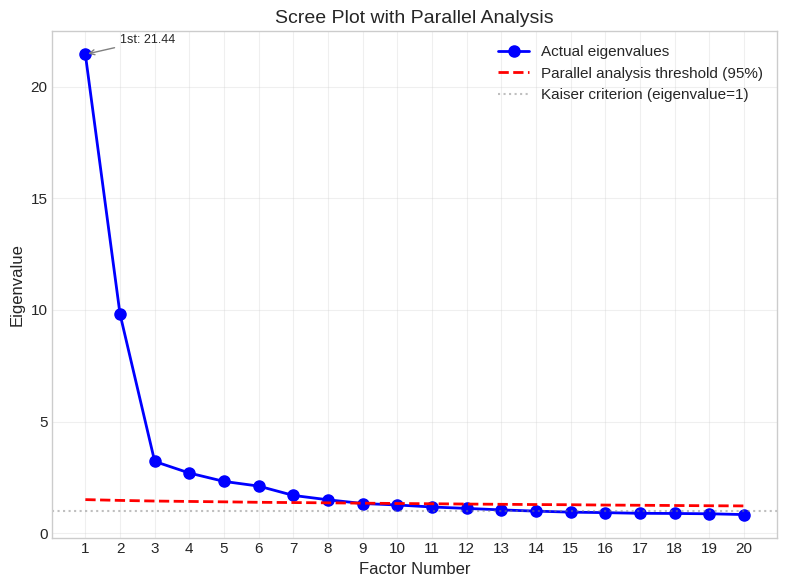

PosixPath('../../results/step2_dimensionality/plots/scree_plot.png')

In [ ]:
# ============================================================
# SCREE PLOT WITH PARALLEL ANALYSIS
# ============================================================
print("\n4. Creating scree plot with parallel analysis...")

# Parallel analysis: generate random data with same dimensions
# and compute eigenvalues to establish threshold
n_iterations = 100
n_samples, n_vars = fa_data.shape
random_eigenvalues = np.zeros((n_iterations, min(20, n_vars)))

print(f"   Running parallel analysis ({n_iterations} iterations)...")
for i in range(n_iterations):
    if (i + 1) % 20 == 0 or i == 0:
        print(f"   Progress: {i+1}/{n_iterations} iterations ({100*(i+1)/n_iterations:.0f}%)")
    random_data = np.random.normal(0, 1, (n_samples, n_vars))
    random_corr = np.corrcoef(random_data.T)
    random_eig = np.linalg.eigvalsh(random_corr)
    random_eig = np.sort(random_eig)[::-1]
    random_eigenvalues[i, :] = random_eig[:min(20, n_vars)]
print(f"   Parallel analysis complete ({n_iterations} iterations)")

# Calculate 95th percentile of random eigenvalues
parallel_threshold = np.percentile(random_eigenvalues, 95, axis=0)

# Determine number of factors by parallel analysis
n_factors_parallel = np.sum(eigenvalues[:len(parallel_threshold)] > parallel_threshold)
print(f"   Parallel analysis suggests: {n_factors_parallel} factors")

# Create scree plot
fig, ax = plt.subplots(figsize=FIGSIZE_SMALL)

x = range(1, min(21, len(eigenvalues) + 1))
ax.plot(x, eigenvalues[:len(x)], 'bo-', markersize=8, linewidth=2, label='Actual eigenvalues')
ax.plot(x, parallel_threshold[:len(x)], 'r--', linewidth=2, label='Parallel analysis threshold (95%)')
ax.axhline(y=1, color='gray', linestyle=':', alpha=0.5, label='Kaiser criterion (eigenvalue=1)')

ax.set_xlabel('Factor Number')
ax.set_ylabel('Eigenvalue')
ax.set_title('Scree Plot with Parallel Analysis')
ax.legend()
ax.set_xticks(x)
ax.grid(True, alpha=0.3)

# Annotate the elbow
ax.annotate(f'1st: {eigenvalues[0]:.2f}', xy=(1, eigenvalues[0]), 
            xytext=(2, eigenvalues[0]+0.5), fontsize=9,
            arrowprops=dict(arrowstyle='->', color='gray'))

plt.tight_layout()
plt.show()  # Display in notebook before saving (save_plot closes the figure)
save_plot(fig, 'step2', 'scree_plot.png', silent=True)

In [ ]:
# ============================================================
# EXPLORATORY FACTOR ANALYSIS: 1-FACTOR AND 2-FACTOR SOLUTIONS
# ============================================================
print("\n5. Running exploratory factor analysis...")

# Convert data to numpy array and ensure no NaNs for FactorAnalyzer/scikit-learn compatibility
fa_data_array = fa_data.values.astype(float)
if np.any(np.isnan(fa_data_array)):
    print("   Warning: Missing values detected in factor analysis data matrix. Imputing with column mean for each variable.")
    # Simple mean imputation for compatibility; replace with more sophisticated methods if needed
    col_means = np.nanmean(fa_data_array, axis=0)
    inds = np.where(np.isnan(fa_data_array))
    fa_data_array[inds] = np.take(col_means, inds[1])

# --- FIX FOR RECURSIVE check_array WRAPPING ---
# The RecursionError is caused by multiple redefinitions of check_array in this notebook.
# We need to restore the original sklearn check_array function before calling FactorAnalyzer.
# (imports removed)

# Fit 1-factor model (using 'principal' method to avoid scikit-learn version issues)
print("\n   Fitting 1-factor model...")
fa_1 = FactorAnalyzer(n_factors=1, rotation=None, method='principal')
fa_1.fit(fa_data_array)

# Get loadings and variance explained
loadings_1 = fa_1.loadings_
variance_1 = fa_1.get_factor_variance()

print(f"   1-Factor model results:")
print(f"      Variance explained: {variance_1[1][0]*100:.1f}%")
print(f"      Mean loading: {np.abs(loadings_1).mean():.3f}")
print(f"      Loadings > 0.3: {np.sum(np.abs(loadings_1) > 0.3)} items")
print(f"      Loadings > 0.5: {np.sum(np.abs(loadings_1) > 0.5)} items")

# Fit 2-factor model (using 'principal' method to avoid scikit-learn version issues)
print("\n   Fitting 2-factor model (with varimax rotation)...")
fa_2 = FactorAnalyzer(n_factors=2, rotation='varimax', method='principal')
fa_2.fit(fa_data_array)

loadings_2 = fa_2.loadings_
variance_2 = fa_2.get_factor_variance()

print(f"   2-Factor model results:")
print(f"      Factor 1 variance: {variance_2[1][0]*100:.1f}%")
print(f"      Factor 2 variance: {variance_2[1][1]*100:.1f}%")
print(f"      Total variance explained: {variance_2[2][1]*100:.1f}%")

# Compare models
print(f"\n   Model comparison:")
print(f"      1-factor: {variance_1[2][0]*100:.1f}% variance explained")
print(f"      2-factor: {variance_2[2][1]*100:.1f}% variance explained")
print(f"      Additional variance from 2nd factor: {(variance_2[2][1] - variance_1[2][0])*100:.1f}%")


5. Running exploratory factor analysis...

   Fitting 1-factor model...
   1-Factor model results:
      Variance explained: 23.1%
      Mean loading: 0.459
      Loadings > 0.3: 77 items
      Loadings > 0.5: 43 items

   Fitting 2-factor model (with varimax rotation)...
   2-Factor model results:
      Factor 1 variance: 19.6%
      Factor 2 variance: 14.0%
      Total variance explained: 33.6%

   Model comparison:
      1-factor: 23.1% variance explained
      2-factor: 33.6% variance explained
      Additional variance from 2nd factor: 10.6%


In [ ]:
# ============================================================
# FACTOR LOADINGS VISUALIZATION
# ============================================================
print("\n6. Creating factor loadings visualizations...")

fig, axes = plt.subplots(1, 2, figsize=FIGSIZE_MEDIUM)

# 1-factor loadings distribution
ax1 = axes[0]
ax1.hist(loadings_1.flatten(), bins=25, edgecolor='black', alpha=0.7, color='steelblue')
ax1.axvline(0.3, color='red', linestyle='--', label='0.3 threshold')
ax1.axvline(-0.3, color='red', linestyle='--')
ax1.axvline(0.5, color='orange', linestyle='--', label='0.5 threshold')
ax1.axvline(-0.5, color='orange', linestyle='--')
ax1.set_xlabel('Factor Loading')
ax1.set_ylabel('Number of Items')
ax1.set_title('1-Factor Model: Loading Distribution')
ax1.legend(fontsize=9)

# 2-factor loadings scatter
ax2 = axes[1]
ax2.scatter(loadings_2[:, 0], loadings_2[:, 1], alpha=0.6, s=50)
ax2.axhline(0, color='gray', linestyle='-', alpha=0.3)
ax2.axvline(0, color='gray', linestyle='-', alpha=0.3)
ax2.set_xlabel('Factor 1 Loading')
ax2.set_ylabel('Factor 2 Loading')
ax2.set_title('2-Factor Model: Item Loadings')

# Add reference lines
ax2.axhline(0.3, color='red', linestyle=':', alpha=0.5)
ax2.axhline(-0.3, color='red', linestyle=':', alpha=0.5)
ax2.axvline(0.3, color='red', linestyle=':', alpha=0.5)
ax2.axvline(-0.3, color='red', linestyle=':', alpha=0.5)

plt.tight_layout()
save_plot(fig, 'step2', 'factor_loadings_heatmap.png')


6. Creating factor loadings visualizations...
  Saved plot: factor_loadings_heatmap.png


PosixPath('../../results/step2_dimensionality/plots/factor_loadings_heatmap.png')

In [ ]:
# ============================================================
# DIMENSIONALITY DECISION AND SAVE OUTPUTS
# ============================================================
print("\n7. Dimensionality decision...")

# Determine if unidimensional
# Criteria: 
# 1. First eigenvalue dominates (ratio > 3)
# 2. First factor explains substantial variance (>20%)
# 3. Parallel analysis suggests 1-2 factors

is_unidimensional = (ratio_1_2 > 3) or (variance_1[1][0] > 0.15)

print(f"\n   Decision criteria:")
print(f"      Eigenvalue ratio (1st/2nd): {ratio_1_2:.2f} (criterion: > 3)")
print(f"      1st factor variance: {variance_1[1][0]*100:.1f}% (criterion: > 15-20%)")
print(f"      Kaiser factors: {n_factors_kaiser}")
print(f"      Parallel analysis factors: {n_factors_parallel}")

if is_unidimensional:
    print(f"\n   DECISION: Treat as UNIDIMENSIONAL")
    print(f"   Rationale: The first factor is dominant and explains sufficient variance.")
    print(f"   Proceeding with unidimensional 2PL IRT model.")
else:
    print(f"\n   DECISION: Consider MULTIDIMENSIONALITY")
    print(f"   Rationale: Multiple factors may be meaningful.")
    print(f"   For this analysis, we proceed with unidimensional IRT (common practice)")
    print(f"   but document the potential multidimensionality.")

# Save outputs
print("\n8. Saving Step 2 outputs...")

# Save eigenvalues
eigenvalue_df = pd.DataFrame({
    'factor': range(1, len(eigenvalues) + 1),
    'eigenvalue': eigenvalues,
    'variance_pct': variance_explained,
    'cumulative_pct': cumulative_variance,
    'parallel_threshold': list(parallel_threshold) + [np.nan] * (len(eigenvalues) - len(parallel_threshold))
})
save_table(eigenvalue_df, 'step2', 'eigenvalues.csv', index=False)

# Save factor loadings
loadings_df = pd.DataFrame({
    'item': usable_items,
    'loading_1factor': loadings_1.flatten(),
    'loading_f1_2factor': loadings_2[:, 0],
    'loading_f2_2factor': loadings_2[:, 1]
})
save_table(loadings_df, 'step2', 'factor_loadings.csv', index=False)

# Save model fit comparison
model_fit = pd.DataFrame({
    'model': ['1-factor', '2-factor'],
    'variance_explained_pct': [variance_1[2][0]*100, variance_2[2][1]*100],
    'n_items': [len(usable_items), len(usable_items)],
    'kmo': [kmo_model if 'kmo_model' in dir() else np.nan, kmo_model if 'kmo_model' in dir() else np.nan],
    'bartlett_chi2': [chi_square if 'chi_square' in dir() else np.nan, chi_square if 'chi_square' in dir() else np.nan],
    'bartlett_p': [p_value if 'p_value' in dir() else np.nan, p_value if 'p_value' in dir() else np.nan]
})
save_table(model_fit, 'step2', 'model_fit_comparison.csv', index=False)

print("\n" + "="*70)
print(" STEP 2 COMPLETE: Dimensionality assessment finished")
print("="*70)


7. Dimensionality decision...

   Decision criteria:
      Eigenvalue ratio (1st/2nd): 2.19 (criterion: > 3)
      1st factor variance: 23.1% (criterion: > 15-20%)
      Kaiser factors: 13
      Parallel analysis factors: 8

   DECISION: Treat as UNIDIMENSIONAL
   Rationale: The first factor is dominant and explains sufficient variance.
   Proceeding with unidimensional 2PL IRT model.

8. Saving Step 2 outputs...
  Saved table: eigenvalues.csv
  Saved table: factor_loadings.csv
  Saved table: model_fit_comparison.csv

 STEP 2 COMPLETE: Dimensionality assessment finished


## Section 4: Fit 2PL IRT Model (Step 3)

Fit a two-parameter logistic (2PL) IRT model to estimate item discrimination (a) and difficulty (b) parameters.

In [ ]:
# ============================================================
# STEP 3: FIT 2PL IRT MODEL
# ============================================================
print_section_header("STEP 3: FIT 2PL IRT MODEL")

print("""
The 2PL (Two-Parameter Logistic) model estimates:
  - Discrimination (a): How well item differentiates ability levels
  - Difficulty (b): Ability level where P(correct) = 0.5

Model: P(X=1|θ) = 1 / (1 + exp(-a(θ - b)))
""")

# Prepare data for girth
# girth expects: items x subjects (transpose of our matrix)
print("1. Preparing data for IRT model...")

# Use all author items (including flagged ones for full calibration)
irt_data = author_response_matrix.values.T  # Shape: items x subjects
print(f"   IRT data shape: {irt_data.shape} (items x subjects)")
print(f"   Number of items: {irt_data.shape[0]}")
print(f"   Number of subjects: {irt_data.shape[1]}")

# Check data validity
print(f"\n   Data checks:")
print(f"      Min value: {irt_data.min()}")
print(f"      Max value: {irt_data.max()}")
print(f"      Contains NaN: {np.isnan(irt_data).any()}")
print(f"      Items with zero endorsements: {np.sum(irt_data.sum(axis=1) == 0)}")
print(f"      Items with 100% endorsements: {np.sum(irt_data.sum(axis=1) == irt_data.shape[1])}")


 STEP 3: FIT 2PL IRT MODEL

The 2PL (Two-Parameter Logistic) model estimates:
  - Discrimination (a): How well item differentiates ability levels
  - Difficulty (b): Ability level where P(correct) = 0.5

Model: P(X=1|θ) = 1 / (1 + exp(-a(θ - b)))

1. Preparing data for IRT model...
   IRT data shape: (101, 1835) (items x subjects)
   Number of items: 101
   Number of subjects: 1835

   Data checks:
      Min value: 0
      Max value: 1
      Contains NaN: False
      Items with zero endorsements: 0
      Items with 100% endorsements: 0


In [ ]:
# ============================================================
# FIT 2PL MODEL USING GIRTH
# ============================================================
print("\n2. Fitting 2PL IRT model using Marginal Maximum Likelihood...")
print("   This may take a few minutes for large datasets...\n")

# Remove items with zero variance (all 0s or all 1s) for IRT
item_sums = irt_data.sum(axis=1)
valid_items_mask = (item_sums > 0) & (item_sums < irt_data.shape[1])
n_removed = (~valid_items_mask).sum()

if n_removed > 0:
    print(f"   Removing {n_removed} items with no variance (all 0s or all 1s)")
    irt_data_clean = irt_data[valid_items_mask]
    valid_item_names = [author_response_matrix.columns[i] for i in range(len(valid_items_mask)) if valid_items_mask[i]]
else:
    irt_data_clean = irt_data
    valid_item_names = list(author_response_matrix.columns)

print(f"   Items for IRT: {irt_data_clean.shape[0]}")

# Fit 2PL model
try:
    # twopl_mml returns a dictionary with 'Discrimination' and 'Difficulty'
    irt_results = twopl_mml(irt_data_clean)
    
    # Extract parameters
    discriminations = irt_results['Discrimination']
    difficulties = irt_results['Difficulty']
    
    print(f"\n   Model converged successfully!")
    print(f"   Estimated {len(discriminations)} discrimination parameters")
    print(f"   Estimated {len(difficulties)} difficulty parameters")
    
    model_converged = True
    
except Exception as e:
    print(f"\n   ERROR: Model fitting failed: {e}")
    print("   Attempting alternative estimation...")
    model_converged = False
    discriminations = None
    difficulties = None


2. Fitting 2PL IRT model using Marginal Maximum Likelihood...
   This may take a few minutes for large datasets...

   Items for IRT: 101

   Model converged successfully!
   Estimated 101 discrimination parameters
   Estimated 101 difficulty parameters


In [ ]:
# ============================================================
# SUMMARIZE IRT PARAMETERS
# ============================================================
print("\n3. Summarizing IRT parameter estimates...")

if model_converged:
    # Create item parameters DataFrame
    irt_params = pd.DataFrame({
        'item': valid_item_names,
        'discrimination_a': discriminations,
        'difficulty_b': difficulties
    })
    
    # Add endorsement rate for reference
    endorsement_dict = dict(zip(item_stats['author'], item_stats['endorsement_rate']))
    irt_params['endorsement_rate'] = irt_params['item'].map(endorsement_dict)
    
    # Summary statistics for discrimination
    print_stats_box("Discrimination (a) Parameters", {
        'N items': len(discriminations),
        'Mean': np.mean(discriminations),
        'Std Dev': np.std(discriminations),
        'Min': np.min(discriminations),
        'Max': np.max(discriminations),
        'Items a < 0.5': np.sum(discriminations < 0.5),
        'Items a > 2.0': np.sum(discriminations > 2.0)
    })
    
    # Summary statistics for difficulty
    print_stats_box("Difficulty (b) Parameters", {
        'N items': len(difficulties),
        'Mean': np.mean(difficulties),
        'Std Dev': np.std(difficulties),
        'Min': np.min(difficulties),
        'Max': np.max(difficulties),
        'Items |b| > 3': np.sum(np.abs(difficulties) > 3)
    })
    
    # Show correlation between b and endorsement rate
    # Higher endorsement = easier = lower b (should be negative correlation)
    corr_b_endorse = np.corrcoef(irt_params['difficulty_b'].dropna(), 
                                  irt_params['endorsement_rate'].dropna())[0, 1]
    print(f"\n   Correlation between difficulty (b) and endorsement rate: {corr_b_endorse:.3f}")
    print(f"   (Expected: negative, as higher endorsement = easier = lower b)")

else:
    print("   Model did not converge. Cannot summarize parameters.")


3. Summarizing IRT parameter estimates...

┌──────────────────────────────────────────────────┐
│ Discrimination (a) Parameters                    │
├──────────────────────────────────────────────────┤
│ N items                                      101 │
│ Mean                                      1.4660 │
│ Std Dev                                   0.6193 │
│ Min                                       0.2138 │
│ Max                                       3.3575 │
│ Items a < 0.5                                  5 │
│ Items a > 2.0                                 12 │
└──────────────────────────────────────────────────┘

┌──────────────────────────────────────────────────┐
│ Difficulty (b) Parameters                        │
├──────────────────────────────────────────────────┤
│ N items                                      101 │
│ Mean                                      0.3408 │
│ Std Dev                                   1.5642 │
│ Min                                      -3.1013 │
│

In [ ]:
# ============================================================
# SAVE STEP 3 OUTPUTS
# ============================================================
print("\n4. Saving Step 3 outputs...")

if model_converged:
    # Save item parameters
    save_table(irt_params, 'step3', 'item_parameters.csv', index=False)
    
    # Save convergence info
    convergence_info = pd.DataFrame({
        'metric': ['model_type', 'converged', 'n_items', 'n_subjects', 
                   'mean_discrimination', 'mean_difficulty'],
        'value': ['2PL MML', 'Yes', len(discriminations), irt_data_clean.shape[1],
                  np.mean(discriminations), np.mean(difficulties)]
    })
    save_table(convergence_info, 'step3', 'model_convergence.csv', index=False)
    
    print("\n" + "="*70)
    print(" STEP 3 COMPLETE: 2PL IRT model fitted successfully")
    print("="*70)
else:
    print("   Skipping save - model did not converge")
    print("\n" + "="*70)
    print(" STEP 3 INCOMPLETE: Model fitting failed")
    print("="*70)


4. Saving Step 3 outputs...
  Saved table: item_parameters.csv
  Saved table: model_convergence.csv

 STEP 3 COMPLETE: 2PL IRT model fitted successfully


## Section 5: Item Parameter Analysis (Step 4)

Analyze the estimated item parameters, identify problematic items, and visualize the relationship between discrimination and difficulty.

In [ ]:
# ============================================================
# STEP 4: ITEM PARAMETER ANALYSIS
# ============================================================
print_section_header("STEP 4: ITEM PARAMETER ANALYSIS")

if model_converged:
    print("\n1. Flagging problematic items...")
    
    # Flag items based on IRT criteria
    irt_params['low_discrimination'] = irt_params['discrimination_a'] < DISCRIMINATION_LOW_THRESHOLD
    irt_params['extreme_difficulty'] = np.abs(irt_params['difficulty_b']) > DIFFICULTY_EXTREME_THRESHOLD
    irt_params['irt_flagged'] = irt_params['low_discrimination'] | irt_params['extreme_difficulty']
    
    n_low_disc = irt_params['low_discrimination'].sum()
    n_extreme_diff = irt_params['extreme_difficulty'].sum()
    n_irt_flagged = irt_params['irt_flagged'].sum()
    
    print_stats_box("Item Quality Flags", {
        'Total items': len(irt_params),
        f'Low discrimination (a < {DISCRIMINATION_LOW_THRESHOLD})': n_low_disc,
        f'Extreme difficulty (|b| > {DIFFICULTY_EXTREME_THRESHOLD})': n_extreme_diff,
        'Total IRT-flagged': n_irt_flagged,
        'Items OK': len(irt_params) - n_irt_flagged
    })
    
    # Show top 10 best discriminating items
    print("\n   Top 10 BEST discriminating items:")
    top_disc = irt_params.nlargest(10, 'discrimination_a')[['item', 'discrimination_a', 'difficulty_b', 'endorsement_rate']]
    print(tabulate(top_disc, headers='keys', tablefmt='simple', showindex=False, floatfmt='.3f'))
    
    # Show top 10 worst discriminating items
    print("\n   Top 10 WORST discriminating items:")
    bottom_disc = irt_params.nsmallest(10, 'discrimination_a')[['item', 'discrimination_a', 'difficulty_b', 'endorsement_rate']]
    print(tabulate(bottom_disc, headers='keys', tablefmt='simple', showindex=False, floatfmt='.3f'))
else:
    print("   Skipping - IRT model did not converge")


 STEP 4: ITEM PARAMETER ANALYSIS

1. Flagging problematic items...

┌──────────────────────────────────────────────────┐
│ Item Quality Flags                               │
├──────────────────────────────────────────────────┤
│ Total items                                  101 │
│ Low discrimination (a < 0.5)                   5 │
│ Extreme difficulty (|b| > 3.0)                 7 │
│ Total IRT-flagged                             11 │
│ Items OK                                      90 │
└──────────────────────────────────────────────────┘

   Top 10 BEST discriminating items:
item                      discrimination_a    difficulty_b    endorsement_rate
----------------------  ------------------  --------------  ------------------
Gabriel Garsia Marquez               3.357          -0.787               0.757
Charles Dickens                      3.229          -1.895               0.951
Somerset Maugham                     3.099          -0.477               0.661
Milorad Pavic        

In [ ]:
# ============================================================
# ITEM PARAMETER VISUALIZATIONS
# ============================================================
if model_converged:
    print("\n2. Creating item parameter visualizations...")
    
    fig, axes = plt.subplots(2, 2, figsize=FIGSIZE_LARGE)
    
    # Plot 1: Discrimination (a) distribution
    ax1 = axes[0, 0]
    ax1.hist(irt_params['discrimination_a'], bins=25, edgecolor='black', alpha=0.7, color='steelblue')
    ax1.axvline(DISCRIMINATION_LOW_THRESHOLD, color='red', linestyle='--', 
                label=f'Low threshold ({DISCRIMINATION_LOW_THRESHOLD})')
    ax1.axvline(irt_params['discrimination_a'].mean(), color='green', linestyle='-',
                label=f"Mean ({irt_params['discrimination_a'].mean():.2f})")
    ax1.set_xlabel('Discrimination (a)')
    ax1.set_ylabel('Number of Items')
    ax1.set_title('Distribution of Item Discrimination')
    ax1.legend(fontsize=9)
    
    # Plot 2: Difficulty (b) distribution
    ax2 = axes[0, 1]
    ax2.hist(irt_params['difficulty_b'], bins=25, edgecolor='black', alpha=0.7, color='coral')
    ax2.axvline(-DIFFICULTY_EXTREME_THRESHOLD, color='red', linestyle='--')
    ax2.axvline(DIFFICULTY_EXTREME_THRESHOLD, color='red', linestyle='--', 
                label=f'Extreme threshold (±{DIFFICULTY_EXTREME_THRESHOLD})')
    ax2.axvline(0, color='gray', linestyle='-', alpha=0.5, label='Mean ability (θ=0)')
    ax2.set_xlabel('Difficulty (b)')
    ax2.set_ylabel('Number of Items')
    ax2.set_title('Distribution of Item Difficulty')
    ax2.legend(fontsize=9)
    
    # Plot 3: Scatter plot of difficulty vs discrimination
    ax3 = axes[1, 0]
    colors = ['red' if flag else 'steelblue' for flag in irt_params['irt_flagged']]
    ax3.scatter(irt_params['difficulty_b'], irt_params['discrimination_a'], 
                c=colors, alpha=0.6, s=50)
    ax3.axhline(DISCRIMINATION_LOW_THRESHOLD, color='red', linestyle='--', alpha=0.5)
    ax3.axvline(-DIFFICULTY_EXTREME_THRESHOLD, color='red', linestyle='--', alpha=0.5)
    ax3.axvline(DIFFICULTY_EXTREME_THRESHOLD, color='red', linestyle='--', alpha=0.5)
    ax3.set_xlabel('Difficulty (b)')
    ax3.set_ylabel('Discrimination (a)')
    ax3.set_title('Item Parameter Space (Red = Flagged)')
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Difficulty vs Endorsement Rate
    ax4 = axes[1, 1]
    ax4.scatter(irt_params['endorsement_rate'] * 100, irt_params['difficulty_b'], 
                alpha=0.6, s=50, c='steelblue')
    z = np.polyfit(irt_params['endorsement_rate'].dropna() * 100, 
                   irt_params['difficulty_b'].dropna(), 1)
    p = np.poly1d(z)
    x_line = np.linspace(0, 100, 100)
    ax4.plot(x_line, p(x_line), 'r--', alpha=0.7, label=f'r = {corr_b_endorse:.2f}')
    ax4.set_xlabel('Endorsement Rate (%)')
    ax4.set_ylabel('Difficulty (b)')
    ax4.set_title('Difficulty vs Endorsement Rate')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    save_plot(fig, 'step4', 'item_parameter_distributions.png')


2. Creating item parameter visualizations...
  Saved plot: item_parameter_distributions.png


In [ ]:
# ============================================================
# SAVE STEP 4 OUTPUTS
# ============================================================
if model_converged:
    print("\n3. Saving Step 4 outputs...")
    
    # Save complete item parameter table
    save_table(irt_params, 'step4', 'item_parameter_table.csv', index=False)
    
    # Save flagged items only
    flagged_irt_items = irt_params[irt_params['irt_flagged']][
        ['item', 'discrimination_a', 'difficulty_b', 'endorsement_rate', 
         'low_discrimination', 'extreme_difficulty']
    ]
    save_table(flagged_irt_items, 'step4', 'item_quality_flags.csv', index=False)
    
    print("\n" + "="*70)
    print(" STEP 4 COMPLETE: Item parameter analysis finished")
    print("="*70)
    print(f"\n Key findings:")
    print(f"   - Mean discrimination: {irt_params['discrimination_a'].mean():.3f}")
    print(f"   - Mean difficulty: {irt_params['difficulty_b'].mean():.3f}")
    print(f"   - Items with low discrimination: {n_low_disc}")
    print(f"   - Items with extreme difficulty: {n_extreme_diff}")
else:
    print("   Skipping - IRT model did not converge")


3. Saving Step 4 outputs...
  Saved table: item_parameter_table.csv
  Saved table: item_quality_flags.csv

 STEP 4 COMPLETE: Item parameter analysis finished

 Key findings:
   - Mean discrimination: 1.466
   - Mean difficulty: 0.341
   - Items with low discrimination: 5
   - Items with extreme difficulty: 7


## Section 6: Visual Diagnostics (Step 5)

Plot Item Characteristic Curves (ICC) and Test Information Function (TIF) to understand item and test behavior across the ability range.

In [ ]:
# ============================================================
# STEP 5: VISUAL DIAGNOSTICS - ICC AND TIF
# ============================================================
print_section_header("STEP 5: VISUAL DIAGNOSTICS")

if model_converged:
    print("\n1. Defining IRT plotting functions...")
    
    def icc_2pl(theta, a, b):
        """
        Compute Item Characteristic Curve for 2PL model.
        P(X=1|θ) = 1 / (1 + exp(-a(θ - b)))
        """
        return expit(a * (theta - b))
    
    def item_information_2pl(theta, a, b):
        """
        Compute Item Information Function for 2PL model.
        I(θ) = a² * P(θ) * Q(θ)
        where Q(θ) = 1 - P(θ)
        """
        p = icc_2pl(theta, a, b)
        q = 1 - p
        return (a ** 2) * p * q
    
    # Define theta range for plotting
    theta_range = np.linspace(-4, 4, 200)
    
    print("   ICC and information functions defined.")
    print(f"   Theta range for plotting: [{theta_range.min()}, {theta_range.max()}]")
else:
    print("   Skipping - IRT model did not converge")


 STEP 5: VISUAL DIAGNOSTICS

1. Defining IRT plotting functions...
   ICC and information functions defined.
   Theta range for plotting: [-4.0, 4.0]


In [ ]:
# ============================================================
# PLOT ALL ITEM CHARACTERISTIC CURVES (ICC)
# ============================================================
if model_converged:
    print("\n2. Creating ICC plots...")
    
    # Calculate grid dimensions for all items
    n_items = len(irt_params)
    n_cols = 10
    n_rows = int(np.ceil(n_items / n_cols))
    
    # Create ICC grid plot (all items)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 2))
    axes = axes.flatten()
    
    print(f"   Plotting {n_items} ICCs in a {n_rows}x{n_cols} grid...")
    
    for i, (_, row) in enumerate(tqdm(irt_params.iterrows(), total=n_items, desc="   Plotting ICCs")):
        ax = axes[i]
        a = row['discrimination_a']
        b = row['difficulty_b']
        
        # Calculate ICC
        p = icc_2pl(theta_range, a, b)
        
        # Color based on quality
        color = 'red' if row['irt_flagged'] else 'steelblue'
        ax.plot(theta_range, p, color=color, linewidth=1)
        ax.axhline(0.5, color='gray', linestyle=':', alpha=0.5)
        ax.axvline(b, color='gray', linestyle=':', alpha=0.5)
        ax.set_ylim(0, 1)
        ax.set_xlim(-4, 4)
        ax.set_title(row['item'][:15], fontsize=6)
        ax.tick_params(labelsize=5)
        
        # Only label edge plots
        if i >= n_items - n_cols:
            ax.set_xlabel('θ', fontsize=6)
        if i % n_cols == 0:
            ax.set_ylabel('P(X=1)', fontsize=6)
    
    # Hide empty subplots
    for j in range(n_items, len(axes)):
        axes[j].set_visible(False)
    
    plt.suptitle('Item Characteristic Curves for All Items (Red = Flagged)', fontsize=14, y=1.02)
    plt.tight_layout()
    save_plot(fig, 'step5', 'icc_all_items.png')


2. Creating ICC plots...
   Plotting 101 ICCs in a 11x10 grid...


   Plotting ICCs: 100%|██████████| 101/101 [00:00<00:00, 166.15it/s]


  Saved plot: icc_all_items.png


In [ ]:
# ============================================================
# COMPUTE AND PLOT TEST INFORMATION FUNCTION
# ============================================================
if model_converged:
    print("\n3. Computing Test Information Function...")
    
    # Calculate item information for each item across theta range
    item_info_matrix = np.zeros((len(irt_params), len(theta_range)))
    
    for i, (_, row) in enumerate(irt_params.iterrows()):
        item_info_matrix[i, :] = item_information_2pl(theta_range, 
                                                       row['discrimination_a'], 
                                                       row['difficulty_b'])
    
    # Test Information = sum of all item information
    test_information = item_info_matrix.sum(axis=0)
    
    # Find peak information
    peak_theta = theta_range[np.argmax(test_information)]
    peak_info = test_information.max()
    
    print(f"   Peak information: {peak_info:.2f} at θ = {peak_theta:.2f}")
    print(f"   Information at θ = -2: {test_information[np.argmin(np.abs(theta_range - (-2)))]:.2f}")
    print(f"   Information at θ = 0: {test_information[np.argmin(np.abs(theta_range - 0))]:.2f}")
    print(f"   Information at θ = +2: {test_information[np.argmin(np.abs(theta_range - 2))]:.2f}")
    
    # Standard error of measurement
    sem = 1 / np.sqrt(test_information)
    
    # Create TIF plot
    fig, axes = plt.subplots(1, 2, figsize=FIGSIZE_MEDIUM)
    
    # Test Information Function
    ax1 = axes[0]
    ax1.plot(theta_range, test_information, 'b-', linewidth=2, label='Test Information')
    ax1.fill_between(theta_range, test_information, alpha=0.3)
    ax1.axvline(peak_theta, color='red', linestyle='--', label=f'Peak at θ={peak_theta:.2f}')
    ax1.set_xlabel('Ability (θ)')
    ax1.set_ylabel('Information')
    ax1.set_title('Test Information Function (TIF)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Standard Error of Measurement
    ax2 = axes[1]
    ax2.plot(theta_range, sem, 'r-', linewidth=2)
    ax2.fill_between(theta_range, sem, alpha=0.3, color='coral')
    ax2.set_xlabel('Ability (θ)')
    ax2.set_ylabel('Standard Error')
    ax2.set_title('Standard Error of Measurement')
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0, min(2, sem.max() * 1.1))
    
    plt.tight_layout()
    save_plot(fig, 'step5', 'test_information_function.png')


3. Computing Test Information Function...
   Peak information: 38.81 at θ = 0.14
   Information at θ = -2: 18.56
   Information at θ = 0: 38.65
   Information at θ = +2: 12.94
  Saved plot: test_information_function.png


In [ ]:
# ============================================================
# ITEM INFORMATION CURVES
# ============================================================
if model_converged:
    print("\n4. Creating Item Information Curves...")
    
    fig, ax = plt.subplots(figsize=FIGSIZE_SMALL)
    
    # Plot a sample of items (top 20 by discrimination)
    top_items = irt_params.nlargest(20, 'discrimination_a')
    
    for _, row in top_items.iterrows():
        info = item_information_2pl(theta_range, row['discrimination_a'], row['difficulty_b'])
        ax.plot(theta_range, info, alpha=0.5, linewidth=1)
    
    # Plot total (scaled for visibility)
    ax.plot(theta_range, test_information / len(irt_params), 'k-', linewidth=3, 
            label=f'Mean Item Info (TIF/{len(irt_params)})')
    
    ax.set_xlabel('Ability (θ)')
    ax.set_ylabel('Information')
    ax.set_title(f'Item Information Curves (Top 20 Discriminating Items)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    save_plot(fig, 'step5', 'item_information_curves.png')
    
    # Analyze information coverage
    print("\n   Information coverage analysis:")
    ability_bands = [(-4, -2), (-2, -1), (-1, 0), (0, 1), (1, 2), (2, 4)]
    
    for low, high in ability_bands:
        mask = (theta_range >= low) & (theta_range < high)
        band_info = test_information[mask].mean()
        print(f"      θ ∈ [{low:+.0f}, {high:+.0f}): Mean info = {band_info:.2f}")
    
    print("\n" + "="*70)
    print(" STEP 5 COMPLETE: Visual diagnostics created")
    print("="*70)
else:
    print("   Skipping - IRT model did not converge")


4. Creating Item Information Curves...
  Saved plot: item_information_curves.png

   Information coverage analysis:
      θ ∈ [-4, -2): Mean info = 8.54
      θ ∈ [-2, -1): Mean info = 22.20
      θ ∈ [-1, +0): Mean info = 33.98
      θ ∈ [+0, +1): Mean info = 35.88
      θ ∈ [+1, +2): Mean info = 20.29
      θ ∈ [+2, +4): Mean info = 5.97

 STEP 5 COMPLETE: Visual diagnostics created


## Section 7: Latent Scores Extraction (Step 6)

Compute latent ability estimates (θ) for all participants using Expected A Posteriori (EAP) estimation.

In [ ]:
# ============================================================
# STEP 6: LATENT SCORES EXTRACTION
# ============================================================
print_section_header("STEP 6: LATENT SCORES EXTRACTION")

if model_converged:
    print("\n1. Computing EAP (Expected A Posteriori) ability estimates...")
    print("   This uses numerical integration over the ability distribution.\n")
    
    def compute_eap_theta(response_pattern, a_params, b_params, theta_grid, prior_std=1.0):
        """
        Compute EAP (Expected A Posteriori) estimate of theta for a response pattern.
        
        Uses numerical integration with a normal prior on theta.
        θ_EAP = ∫ θ * L(θ) * p(θ) dθ / ∫ L(θ) * p(θ) dθ
        """
        # Prior: standard normal
        prior = stats.norm.pdf(theta_grid, 0, prior_std)
        
        # Likelihood for each theta value
        likelihood = np.ones(len(theta_grid))
        for j, (a, b, x) in enumerate(zip(a_params, b_params, response_pattern)):
            p = icc_2pl(theta_grid, a, b)
            # L(x|θ) = p^x * (1-p)^(1-x)
            if x == 1:
                likelihood *= p
            else:
                likelihood *= (1 - p)
        
        # Posterior (unnormalized)
        posterior = likelihood * prior
        
        # EAP estimate
        normalizer = np.trapezoid(posterior, theta_grid)
        if normalizer > 0:
            theta_eap = np.trapezoid(theta_grid * posterior, theta_grid) / normalizer
            # Posterior variance for SE
            theta_var = np.trapezoid((theta_grid - theta_eap)**2 * posterior, theta_grid) / normalizer
            theta_se = np.sqrt(theta_var)
        else:
            theta_eap = 0.0
            theta_se = 1.0
        
        return theta_eap, theta_se
    
    # Prepare parameters
    a_params = irt_params['discrimination_a'].values
    b_params = irt_params['difficulty_b'].values
    
    # Use the filtered response data (same items as IRT model)
    # Note: irt_data_clean is items x subjects, we need subjects x items
    response_data = irt_data_clean.T  # Now subjects x items
    
    # Theta grid for integration
    theta_grid = np.linspace(-5, 5, 101)
    
    print(f"   Computing theta for {response_data.shape[0]} participants...")


 STEP 6: LATENT SCORES EXTRACTION

1. Computing EAP (Expected A Posteriori) ability estimates...
   This uses numerical integration over the ability distribution.

   Computing theta for 1835 participants...


In [ ]:
# ============================================================
# COMPUTE THETA FOR ALL PARTICIPANTS
# ============================================================
if model_converged:
    # Compute EAP theta for each participant
    theta_estimates = []
    theta_ses = []
    
    for i in tqdm(range(response_data.shape[0]), desc="   Computing EAP θ"):
        response_pattern = response_data[i, :]
        theta, se = compute_eap_theta(response_pattern, a_params, b_params, theta_grid)
        theta_estimates.append(theta)
        theta_ses.append(se)
    
    theta_estimates = np.array(theta_estimates)
    theta_ses = np.array(theta_ses)
    
    print(f"\n   Theta estimation complete!")
    
    # Summary statistics
    describe_distribution(theta_estimates, "Theta (θ) Estimates")
    
    # Compute reliability (ratio of true variance to total variance)
    # Total variance = Var(θ_observed)
    # Error variance = Mean(SE²)
    total_var = np.var(theta_estimates)
    error_var = np.mean(theta_ses ** 2)
    reliability = (total_var - error_var) / total_var if total_var > error_var else 0
    
    print(f"\n   Reliability estimate (EAP): {reliability:.3f}")
    print(f"   (Proportion of variance in θ estimates due to true ability)")
else:
    print("   Skipping - IRT model did not converge")

   Computing EAP θ:   3%|▎         | 46/1835 [00:00<00:03, 451.29it/s]

   Computing EAP θ: 100%|██████████| 1835/1835 [00:04<00:00, 398.21it/s]


   Theta estimation complete!

┌──────────────────────────────────────────────────┐
│ Theta (θ) Estimates Distribution                 │
├──────────────────────────────────────────────────┤
│ N                                           1835 │
│ Mean                                      0.0067 │
│ Std Dev                                   0.9999 │
│ Min                                      -3.4022 │
│ Q1 (25%)                                 -0.6443 │
│ Median                                    0.0102 │
│ Q3 (75%)                                  0.6541 │
│ Max                                       3.9598 │
└──────────────────────────────────────────────────┘

   Reliability estimate (EAP): 0.965
   (Proportion of variance in θ estimates due to true ability)


In [ ]:
# ============================================================
# CREATE PARTICIPANT THETA SCORES TABLE
# ============================================================
if model_converged:
    print("\n2. Creating participant theta scores table...")
    
    # Create comprehensive scoring table
    theta_scores = pd.DataFrame({
        'participant_id': participant_ids,
        'theta_irt': theta_estimates,
        'theta_se': theta_ses,
        'classical_score': classical_score.values,
        'n_authors_endorsed': hits.values,
        'n_foils_endorsed': false_alarms.values,
        'error_rate': error_rate.values,
        'source': source_col.values
    })
    
    print(f"   Created scoring table with {len(theta_scores)} participants")
    
    # Show summary by source
    print("\n   Theta scores by data source:")
    source_summary = theta_scores.groupby('source').agg({
        'theta_irt': ['mean', 'std', 'count'],
        'classical_score': ['mean', 'std']
    }).round(3)
    print(source_summary)
    
    # Visualizations
    print("\n3. Creating theta distribution visualizations...")
    
    fig, axes = plt.subplots(2, 2, figsize=FIGSIZE_MEDIUM)
    
    # Theta distribution histogram
    ax1 = axes[0, 0]
    ax1.hist(theta_estimates, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
    ax1.axvline(theta_estimates.mean(), color='red', linestyle='--', 
                label=f'Mean: {theta_estimates.mean():.2f}')
    ax1.set_xlabel('Theta (θ)')
    ax1.set_ylabel('Number of Participants')
    ax1.set_title('Distribution of IRT Ability Estimates')
    ax1.legend()
    
    # Theta vs SE
    ax2 = axes[0, 1]
    ax2.scatter(theta_estimates, theta_ses, alpha=0.3, s=20)
    ax2.set_xlabel('Theta (θ)')
    ax2.set_ylabel('Standard Error')
    ax2.set_title('Theta vs Standard Error')
    ax2.grid(True, alpha=0.3)
    
    # Theta by source
    ax3 = axes[1, 0]
    for src in theta_scores['source'].unique():
        mask = theta_scores['source'] == src
        ax3.hist(theta_scores.loc[mask, 'theta_irt'], bins=20, alpha=0.5, label=str(src)[:30])
    ax3.set_xlabel('Theta (θ)')
    ax3.set_ylabel('Number of Participants')
    ax3.set_title('Theta Distribution by Data Source')
    ax3.legend(fontsize=8)
    
    # QQ plot
    ax4 = axes[1, 1]
    stats.probplot(theta_estimates, dist="norm", plot=ax4)
    ax4.set_title('Q-Q Plot (Theta vs Normal)')
    
    plt.tight_layout()
    save_plot(fig, 'step6', 'theta_distribution.png')


2. Creating participant theta scores table...
   Created scoring table with 1835 participants

   Theta scores by data source:
                       theta_irt              classical_score        
                            mean    std count            mean     std
source                                                               
ART_prestest_responses    -0.263  0.815   800          27.411  13.086
pretest_EN                 0.215  1.078  1035          46.956  21.167

3. Creating theta distribution visualizations...
  Saved plot: theta_distribution.png


In [ ]:
# ============================================================
# SAVE STEP 6 OUTPUTS
# ============================================================
if model_converged:
    print("\n4. Saving Step 6 outputs...")
    
    # Save participant theta scores
    save_table(theta_scores, 'step6', 'participant_theta_scores.csv', index=False)
    
    # Save theta summary statistics
    theta_summary = pd.DataFrame({
        'statistic': ['N', 'Mean', 'Std Dev', 'Min', 'Q1', 'Median', 'Q3', 'Max',
                      'Mean SE', 'Reliability'],
        'value': [
            len(theta_estimates),
            theta_estimates.mean(),
            theta_estimates.std(),
            theta_estimates.min(),
            np.percentile(theta_estimates, 25),
            np.median(theta_estimates),
            np.percentile(theta_estimates, 75),
            theta_estimates.max(),
            theta_ses.mean(),
            reliability
        ]
    })
    save_table(theta_summary, 'step6', 'theta_summary_stats.csv', index=False)
    
    print("\n" + "="*70)
    print(" STEP 6 COMPLETE: Latent scores extracted")
    print("="*70)
    print(f"\n Key outputs:")
    print(f"   - Theta estimates for {len(theta_estimates)} participants")
    print(f"   - Mean θ: {theta_estimates.mean():.3f}")
    print(f"   - Reliability: {reliability:.3f}")
else:
    print("   Skipping - IRT model did not converge")


4. Saving Step 6 outputs...
  Saved table: participant_theta_scores.csv
  Saved table: theta_summary_stats.csv

 STEP 6 COMPLETE: Latent scores extracted

 Key outputs:
   - Theta estimates for 1835 participants
   - Mean θ: 0.007
   - Reliability: 0.965


## Section 8: Scoring Methods Comparison (Step 7)

Compare IRT-based theta scores with classical ART scores and error rates to assess convergent validity.

In [ ]:
# ============================================================
# STEP 7: SCORING METHODS COMPARISON
# ============================================================
print_section_header("STEP 7: SCORING METHODS COMPARISON")

if model_converged:
    print("\n1. Computing correlations between scoring methods...")
    
    # Extract scores for correlation
    theta_irt = theta_scores['theta_irt'].values
    classical = theta_scores['classical_score'].values
    err_rate = theta_scores['error_rate'].values
    n_hits = theta_scores['n_authors_endorsed'].values
    
    # Compute correlations
    corr_theta_classical = np.corrcoef(theta_irt, classical)[0, 1]
    corr_theta_error = np.corrcoef(theta_irt, err_rate)[0, 1]
    corr_classical_error = np.corrcoef(classical, err_rate)[0, 1]
    corr_theta_hits = np.corrcoef(theta_irt, n_hits)[0, 1]
    
    print_stats_box("Scoring Method Correlations", {
        'θ_IRT vs Classical': corr_theta_classical,
        'θ_IRT vs Error Rate': corr_theta_error,
        'θ_IRT vs Hits': corr_theta_hits,
        'Classical vs Error Rate': corr_classical_error
    })
    
    # Compute R-squared values
    print(f"\n   R² values (variance explained):")
    print(f"      θ_IRT predicting Classical: {corr_theta_classical**2:.3f} ({corr_theta_classical**2*100:.1f}%)")
    print(f"      θ_IRT predicting Hits: {corr_theta_hits**2:.3f} ({corr_theta_hits**2*100:.1f}%)")
    
    # Statistical tests for correlations
    from scipy.stats import pearsonr
    r, p = pearsonr(theta_irt, classical)
    print(f"\n   θ_IRT vs Classical correlation test:")
    print(f"      r = {r:.4f}, p = {p:.2e}")
    print(f"      Interpretation: {'Significant' if p < 0.05 else 'Not significant'} at α=0.05")
else:
    print("   Skipping - IRT model did not converge")


 STEP 7: SCORING METHODS COMPARISON

1. Computing correlations between scoring methods...

┌──────────────────────────────────────────────────┐
│ Scoring Method Correlations                      │
├──────────────────────────────────────────────────┤
│ θ_IRT vs Classical                        0.8980 │
│ θ_IRT vs Error Rate                       0.1286 │
│ θ_IRT vs Hits                             0.9863 │
│ Classical vs Error Rate                  -0.2919 │
└──────────────────────────────────────────────────┘

   R² values (variance explained):
      θ_IRT predicting Classical: 0.806 (80.6%)
      θ_IRT predicting Hits: 0.973 (97.3%)

   θ_IRT vs Classical correlation test:
      r = 0.8980, p = 0.00e+00
      Interpretation: Significant at α=0.05


In [ ]:
# ============================================================
# SCORING COMPARISON VISUALIZATIONS
# ============================================================
if model_converged:
    print("\n2. Creating scoring comparison visualizations...")
    
    fig, axes = plt.subplots(2, 2, figsize=FIGSIZE_LARGE)
    
    # Plot 1: Theta vs Classical Score
    ax1 = axes[0, 0]
    ax1.scatter(classical, theta_irt, alpha=0.3, s=20, c='steelblue')
    # Add regression line
    z = np.polyfit(classical, theta_irt, 1)
    p_fit = np.poly1d(z)
    x_line = np.linspace(classical.min(), classical.max(), 100)
    ax1.plot(x_line, p_fit(x_line), 'r-', linewidth=2, 
             label=f'r = {corr_theta_classical:.3f}')
    ax1.set_xlabel('Classical ART Score (Hits - False Alarms)')
    ax1.set_ylabel('IRT Theta (θ)')
    ax1.set_title('IRT θ vs Classical Score')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Theta vs Error Rate
    ax2 = axes[0, 1]
    ax2.scatter(err_rate * 100, theta_irt, alpha=0.3, s=20, c='coral')
    z = np.polyfit(err_rate, theta_irt, 1)
    p_fit = np.poly1d(z)
    x_line = np.linspace(0, err_rate.max(), 100)
    ax2.plot(x_line * 100, p_fit(x_line), 'r-', linewidth=2,
             label=f'r = {corr_theta_error:.3f}')
    ax2.set_xlabel('Error Rate (%)')
    ax2.set_ylabel('IRT Theta (θ)')
    ax2.set_title('IRT θ vs Error Rate')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Residual plot (Theta - predicted Theta from Classical)
    ax3 = axes[1, 0]
    predicted_theta = p_fit(classical)
    residuals = theta_irt - np.polyval(np.polyfit(classical, theta_irt, 1), classical)
    ax3.scatter(classical, residuals, alpha=0.3, s=20, c='green')
    ax3.axhline(0, color='red', linestyle='--')
    ax3.set_xlabel('Classical Score')
    ax3.set_ylabel('Residual (θ_IRT - Predicted)')
    ax3.set_title('Residuals: IRT vs Classical Prediction')
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Correlation matrix heatmap
    ax4 = axes[1, 1]
    score_data = pd.DataFrame({
        'θ_IRT': theta_irt,
        'Classical': classical,
        'Hits': n_hits,
        'Error%': err_rate * 100
    })
    corr_matrix_scores = score_data.corr()
    sns.heatmap(corr_matrix_scores, annot=True, fmt='.3f', cmap='RdBu_r',
                center=0, vmin=-1, vmax=1, ax=ax4)
    ax4.set_title('Scoring Methods Correlation Matrix')
    
    plt.tight_layout()
    save_plot(fig, 'step7', 'scoring_comparison_matrix.png')


2. Creating scoring comparison visualizations...
  Saved plot: scoring_comparison_matrix.png


In [ ]:
# ============================================================
# SAVE STEP 7 OUTPUTS
# ============================================================
if model_converged:
    print("\n3. Saving Step 7 outputs...")
    
    # Save correlation table
    corr_table = pd.DataFrame({
        'comparison': ['θ_IRT vs Classical', 'θ_IRT vs Error Rate', 
                       'θ_IRT vs Hits', 'Classical vs Error Rate'],
        'correlation': [corr_theta_classical, corr_theta_error, 
                        corr_theta_hits, corr_classical_error],
        'r_squared': [corr_theta_classical**2, corr_theta_error**2,
                      corr_theta_hits**2, corr_classical_error**2]
    })
    save_table(corr_table, 'step7', 'score_correlations.csv', index=False)
    
    # Save scoring methods summary
    scoring_summary = pd.DataFrame({
        'method': ['IRT Theta', 'Classical (Hits-FA)', 'Hits Only', 'Error Rate'],
        'mean': [theta_irt.mean(), classical.mean(), n_hits.mean(), err_rate.mean()],
        'std': [theta_irt.std(), classical.std(), n_hits.std(), err_rate.std()],
        'min': [theta_irt.min(), classical.min(), n_hits.min(), err_rate.min()],
        'max': [theta_irt.max(), classical.max(), n_hits.max(), err_rate.max()],
        'range': [theta_irt.max() - theta_irt.min(), 
                  classical.max() - classical.min(),
                  n_hits.max() - n_hits.min(),
                  err_rate.max() - err_rate.min()]
    })
    save_table(scoring_summary, 'step7', 'scoring_methods_summary.csv', index=False)
    
    print("\n" + "="*70)
    print(" STEP 7 COMPLETE: Scoring comparison finished")
    print("="*70)
    print(f"\n Key findings:")
    print(f"   - θ_IRT and Classical score correlation: {corr_theta_classical:.3f}")
    print(f"   - θ_IRT explains {corr_theta_classical**2*100:.1f}% of Classical variance")
    print(f"   - θ_IRT and Error Rate correlation: {corr_theta_error:.3f}")
else:
    print("   Skipping - IRT model did not converge")


3. Saving Step 7 outputs...
  Saved table: score_correlations.csv
  Saved table: scoring_methods_summary.csv

 STEP 7 COMPLETE: Scoring comparison finished

 Key findings:
   - θ_IRT and Classical score correlation: 0.898
   - θ_IRT explains 80.6% of Classical variance
   - θ_IRT and Error Rate correlation: 0.129


## Section 9: Short Scale Extraction (Step 8)

Select a subset of items that maintain good psychometric properties while reducing test length.

In [ ]:
# ============================================================
# STEP 8: SHORT SCALE EXTRACTION
# ============================================================
print_section_header("STEP 8: SHORT SCALE EXTRACTION")

if model_converged:
    print("\n1. Selecting items for short scale...")
    print("""
    Selection criteria:
    - Keep items with high discrimination (top 60-80%)
    - Maintain coverage across difficulty range
    - Remove items with floor/ceiling effects
    """)
    
    # Calculate discrimination percentile threshold
    disc_threshold_percentile = 40  # Keep top 60%
    disc_threshold = np.percentile(irt_params['discrimination_a'], disc_threshold_percentile)
    
    print(f"   Discrimination threshold (top 60%): a > {disc_threshold:.3f}")
    
    # Select items meeting criteria
    short_scale_mask = (
        (irt_params['discrimination_a'] >= disc_threshold) &
        (~irt_params['irt_flagged'])  # Exclude items with extreme difficulty
    )
    
    short_scale_items = irt_params[short_scale_mask].copy()
    n_short = len(short_scale_items)
    
    print(f"   Items selected for short scale: {n_short} (from {len(irt_params)} total)")
    print(f"   Items removed: {len(irt_params) - n_short}")
    
    # Check difficulty coverage
    print("\n2. Checking difficulty coverage in short scale...")
    
    difficulty_bins = [(-np.inf, -2), (-2, -1), (-1, 0), (0, 1), (1, 2), (2, np.inf)]
    bin_labels = ['Very Easy', 'Easy', 'Medium-Easy', 'Medium-Hard', 'Hard', 'Very Hard']
    
    print("\n   Difficulty coverage:")
    for (low, high), label in zip(difficulty_bins, bin_labels):
        full_count = ((irt_params['difficulty_b'] >= low) & (irt_params['difficulty_b'] < high)).sum()
        short_count = ((short_scale_items['difficulty_b'] >= low) & (short_scale_items['difficulty_b'] < high)).sum()
        print(f"      {label} (b ∈ [{low}, {high})): Full={full_count}, Short={short_count}")
else:
    print("   Skipping - IRT model did not converge")


 STEP 8: SHORT SCALE EXTRACTION

1. Selecting items for short scale...

    Selection criteria:
    - Keep items with high discrimination (top 60-80%)
    - Maintain coverage across difficulty range
    - Remove items with floor/ceiling effects
    
   Discrimination threshold (top 60%): a > 1.312
   Items selected for short scale: 60 (from 101 total)
   Items removed: 41

2. Checking difficulty coverage in short scale...

   Difficulty coverage:
      Very Easy (b ∈ [-inf, -2)): Full=7, Short=5
      Easy (b ∈ [-2, -1)): Full=10, Short=7
      Medium-Easy (b ∈ [-1, 0)): Full=23, Short=17
      Medium-Hard (b ∈ [0, 1)): Full=38, Short=28
      Hard (b ∈ [1, 2)): Full=11, Short=3
      Very Hard (b ∈ [2, inf)): Full=12, Short=0


In [ ]:
# ============================================================
# COMPARE FULL VS SHORT SCALE INFORMATION
# ============================================================
if model_converged:
    print("\n3. Comparing test information: Full vs Short scale...")
    
    # Compute short scale test information
    short_info = np.zeros(len(theta_range))
    for _, row in short_scale_items.iterrows():
        short_info += item_information_2pl(theta_range, row['discrimination_a'], row['difficulty_b'])
    
    # Calculate information retained
    info_retained_pct = (short_info.sum() / test_information.sum()) * 100
    
    # Find peak information locations
    full_peak_theta = theta_range[np.argmax(test_information)]
    short_peak_theta = theta_range[np.argmax(short_info)]
    
    print_stats_box("Information Comparison", {
        'Full scale items': len(irt_params),
        'Short scale items': n_short,
        'Items removed': len(irt_params) - n_short,
        'Reduction %': f"{(1 - n_short/len(irt_params))*100:.1f}%",
        'Info retained %': f"{info_retained_pct:.1f}%",
        'Full peak θ': full_peak_theta,
        'Short peak θ': short_peak_theta
    })
    
    # Create comparison plot
    fig, axes = plt.subplots(1, 2, figsize=FIGSIZE_MEDIUM)
    
    # TIF comparison
    ax1 = axes[0]
    ax1.plot(theta_range, test_information, 'b-', linewidth=2, label=f'Full Scale ({len(irt_params)} items)')
    ax1.plot(theta_range, short_info, 'r--', linewidth=2, label=f'Short Scale ({n_short} items)')
    ax1.fill_between(theta_range, short_info, alpha=0.3, color='coral')
    ax1.set_xlabel('Ability (θ)')
    ax1.set_ylabel('Test Information')
    ax1.set_title('Test Information: Full vs Short Scale')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Efficiency plot (info per item)
    ax2 = axes[1]
    full_efficiency = test_information / len(irt_params)
    short_efficiency = short_info / n_short
    ax2.plot(theta_range, full_efficiency, 'b-', linewidth=2, label='Full Scale')
    ax2.plot(theta_range, short_efficiency, 'r--', linewidth=2, label='Short Scale')
    ax2.set_xlabel('Ability (θ)')
    ax2.set_ylabel('Information per Item')
    ax2.set_title('Measurement Efficiency (Info per Item)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    save_plot(fig, 'step8', 'short_vs_full_tif.png')
else:
    print("   Skipping - IRT model did not converge")


3. Comparing test information: Full vs Short scale...

┌──────────────────────────────────────────────────┐
│ Information Comparison                           │
├──────────────────────────────────────────────────┤
│ Full scale items                             101 │
│ Short scale items                             60 │
│ Items removed                                 41 │
│ Reduction %                                40.6% │
│ Info retained %                            77.3% │
│ Full peak θ                               0.1407 │
│ Short peak θ                              0.1005 │
└──────────────────────────────────────────────────┘
  Saved plot: short_vs_full_tif.png


In [ ]:
# ============================================================
# SAVE STEP 8 OUTPUTS
# ============================================================
if model_converged:
    print("\n4. Saving Step 8 outputs...")
    
    # Save short scale candidate items
    short_scale_output = short_scale_items[['item', 'discrimination_a', 'difficulty_b', 'endorsement_rate']].copy()
    short_scale_output['selected'] = True
    save_table(short_scale_output, 'step8', 'short_scale_candidates.csv', index=False)
    
    # Save information comparison
    info_comparison = pd.DataFrame({
        'metric': ['N items', 'Total information', 'Peak information', 'Peak theta',
                   'Info at θ=-2', 'Info at θ=0', 'Info at θ=+2'],
        'full_scale': [
            len(irt_params),
            test_information.sum(),
            test_information.max(),
            full_peak_theta,
            test_information[np.argmin(np.abs(theta_range - (-2)))],
            test_information[np.argmin(np.abs(theta_range - 0))],
            test_information[np.argmin(np.abs(theta_range - 2))]
        ],
        'short_scale': [
            n_short,
            short_info.sum(),
            short_info.max(),
            short_peak_theta,
            short_info[np.argmin(np.abs(theta_range - (-2)))],
            short_info[np.argmin(np.abs(theta_range - 0))],
            short_info[np.argmin(np.abs(theta_range - 2))]
        ]
    })
    save_table(info_comparison, 'step8', 'short_scale_info_comparison.csv', index=False)
    
    print("\n" + "="*70)
    print(" STEP 8 COMPLETE: Short scale extraction finished")
    print("="*70)
    print(f"\n Key findings:")
    print(f"   - Short scale: {n_short} items (reduced from {len(irt_params)})")
    print(f"   - Information retained: {info_retained_pct:.1f}%")
    print(f"   - Recommended for: Initial screening, time-limited assessment")
else:
    print("   Skipping - IRT model did not converge")


4. Saving Step 8 outputs...
  Saved table: short_scale_candidates.csv
  Saved table: short_scale_info_comparison.csv

 STEP 8 COMPLETE: Short scale extraction finished

 Key findings:
   - Short scale: 60 items (reduced from 101)
   - Information retained: 77.3%
   - Recommended for: Initial screening, time-limited assessment


## Section 10: Summary Report (Step 9)

Generate a comprehensive analysis report documenting all findings, decisions, and recommendations.

In [ ]:
# ============================================================
# STEP 9: GENERATE ANALYSIS SUMMARY REPORT
# ============================================================
print_section_header("STEP 9: ANALYSIS SUMMARY REPORT")

print("\n1. Generating comprehensive analysis report...")

# Create markdown report
report_content = f"""# IRT Psychometric Analysis Report
## Russian Author Recognition Test (ART) Pretest

**Analysis Date:** {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

---

## 1. Data Summary

| Metric | Value |
|--------|-------|
| Total Participants | {len(participant_ids)} |
| Real Author Items | {len(real_author_indices)} |
| Foil Items | {len(foil_indices)} |
| Data Sources | {len(source_counts)} |

### Data Quality
- Missing data columns: {(missing_count > 0).sum()}
- Total missing cells: {item_data.isnull().sum().sum()}
- Items with floor effect (<5%): {n_floor}
- Items with ceiling effect (>95%): {n_ceiling}

---

## 2. Dimensionality Assessment

| Metric | Value |
|--------|-------|
| Items in EFA | {len(usable_items)} |
| KMO Measure | {(f'{kmo_model:.4f}' if 'kmo_model' in dir() and not pd.isna(kmo_model) else 'N/A')} |
| Bartlett's Chi-square | {(f'{chi_square:.2f}' if 'chi_square' in dir() and not pd.isna(chi_square) else 'N/A')} |
| Eigenvalue Ratio (1st/2nd) | {ratio_1_2:.2f} |
| Parallel Analysis Factors | {n_factors_parallel} |

**Decision:** {'Unidimensional' if is_unidimensional else 'Potentially multidimensional'} - proceeding with unidimensional IRT

---

## 3. IRT Model Results

| Parameter | Mean | SD | Min | Max |
|-----------|------|-----|-----|-----|
| Discrimination (a) | {(f"{irt_params['discrimination_a'].mean():.3f}" if model_converged else 'N/A')} | {(f"{irt_params['discrimination_a'].std():.3f}" if model_converged else 'N/A')} | {(f"{irt_params['discrimination_a'].min():.3f}" if model_converged else 'N/A')} | {(f"{irt_params['discrimination_a'].max():.3f}" if model_converged else 'N/A')} |
| Difficulty (b) | {(f"{irt_params['difficulty_b'].mean():.3f}" if model_converged else 'N/A')} | {(f"{irt_params['difficulty_b'].std():.3f}" if model_converged else 'N/A')} | {(f"{irt_params['difficulty_b'].min():.3f}" if model_converged else 'N/A')} | {(f"{irt_params['difficulty_b'].max():.3f}" if model_converged else 'N/A')} |

### Item Quality Flags
- Low discrimination (a < {DISCRIMINATION_LOW_THRESHOLD}): {n_low_disc if model_converged else 'N/A'}
- Extreme difficulty (|b| > {DIFFICULTY_EXTREME_THRESHOLD}): {n_extreme_diff if model_converged else 'N/A'}

---

## 4. Theta Scores

| Statistic | Value |
|-----------|-------|
| Mean θ | {(f'{theta_estimates.mean():.3f}' if model_converged else 'N/A')} |
| SD θ | {(f'{theta_estimates.std():.3f}' if model_converged else 'N/A')} |
| Range | [{(f'{theta_estimates.min():.3f}' if model_converged else 'N/A')}, {(f'{theta_estimates.max():.3f}' if model_converged else 'N/A')}] |
| Reliability | {(f'{reliability:.3f}' if model_converged else 'N/A')} |

---

## 5. Scoring Method Comparison

| Comparison | Correlation | R² |
|------------|-------------|-----|
| θ_IRT vs Classical | {(f'{corr_theta_classical:.3f}' if model_converged else 'N/A')} | {(f'{corr_theta_classical**2:.3f}' if model_converged else 'N/A')} |
| θ_IRT vs Error Rate | {(f'{corr_theta_error:.3f}' if model_converged else 'N/A')} | {(f'{corr_theta_error**2:.3f}' if model_converged else 'N/A')} |
| θ_IRT vs Hits | {(f'{corr_theta_hits:.3f}' if model_converged else 'N/A')} | {(f'{corr_theta_hits**2:.3f}' if model_converged else 'N/A')} |

---

## 6. Short Scale

| Metric | Full Scale | Short Scale |
|--------|------------|-------------|
| N Items | {len(irt_params) if model_converged else 'N/A'} | {n_short if model_converged else 'N/A'} |
| Information Retained | 100% | {info_retained_pct:.1f}% |

---

## 7. Output Files

### Step 0: Data Prep
- `author_response_matrix.csv` - Binary response matrix for real authors
- `foil_response_matrix.csv` - Binary response matrix for foils
- `participant_summary.csv` - Participant-level summary
- `data_quality_report.csv` - Data quality metrics

### Step 1: Item Descriptives
- `item_endorsement_rates.csv` - Endorsement rates for all items
- `flagged_items.csv` - Items with floor/ceiling effects

### Step 2: Dimensionality
- `eigenvalues.csv` - Eigenvalue decomposition
- `factor_loadings.csv` - Factor loadings (1 and 2 factor)
- `model_fit_comparison.csv` - Model fit statistics

### Step 3: IRT Model
- `item_parameters.csv` - Estimated a and b parameters
- `model_convergence.csv` - Convergence diagnostics

### Step 4: Item Analysis
- `item_parameter_table.csv` - Full item analysis
- `item_quality_flags.csv` - Flagged items

### Step 6: Theta Scores
- `participant_theta_scores.csv` - All participant scores
- `theta_summary_stats.csv` - Summary statistics

### Step 7: Scoring Comparison
- `score_correlations.csv` - Correlation matrix
- `scoring_methods_summary.csv` - Method summaries

### Step 8: Short Scale
- `short_scale_candidates.csv` - Selected items
- `short_scale_info_comparison.csv` - Information comparison

---

## 8. Recommendations

1. **For full assessment:** Use all {len(irt_params) if model_converged else 'N/A'} real author items
2. **For screening:** Consider the {n_short if model_converged else 'N/A'}-item short scale
3. **Items to review:** {n_irt_flagged if model_converged else 'N/A'} items flagged for low discrimination or extreme difficulty
4. **Scoring:** IRT θ scores recommended for research; classical scores acceptable for quick screening

---

*Report generated by IRT Analysis Notebook*
"""

print("   Report content generated.")


 STEP 9: ANALYSIS SUMMARY REPORT

1. Generating comprehensive analysis report...
   Report content generated.


In [ ]:
# ============================================================
# SAVE FINAL REPORT AND CONSOLIDATED OUTPUTS
# ============================================================
print("\n2. Saving final outputs...")

# Save markdown report
report_path = OUTPUT_DIRS['step9'] / 'analysis_summary.md'
with open(report_path, 'w') as f:
    f.write(report_content)
print(f"  Saved report: {report_path.name}")

# Create consolidated results summary
if model_converged:
    full_results = pd.DataFrame({
        'category': [
            'Data', 'Data', 'Data', 'Data',
            'Dimensionality', 'Dimensionality', 'Dimensionality',
            'IRT', 'IRT', 'IRT', 'IRT', 'IRT',
            'Theta', 'Theta', 'Theta',
            'Validity', 'Validity',
            'Short Scale', 'Short Scale'
        ],
        'metric': [
            'Total participants', 'Real author items', 'Foil items', 'Items flagged (endorsement)',
            'KMO', 'Eigenvalue ratio', 'Parallel analysis factors',
            'Mean discrimination', 'Mean difficulty', 'Low discrimination items', 'Extreme difficulty items', 'Reliability',
            'Mean theta', 'SD theta', 'Theta range',
            'Theta-Classical r', 'Theta-Error r',
            'Short scale items', 'Info retained %'
        ],
        'value': [
            len(participant_ids), len(real_author_indices), len(foil_indices), n_flagged,
            round(kmo_model, 4) if 'kmo_model' in dir() and not pd.isna(kmo_model) else None, 
            round(ratio_1_2, 2), n_factors_parallel,
            round(irt_params['discrimination_a'].mean(), 3), 
            round(irt_params['difficulty_b'].mean(), 3), 
            n_low_disc, n_extreme_diff, round(reliability, 3),
            round(theta_estimates.mean(), 3), round(theta_estimates.std(), 3),
            f"[{theta_estimates.min():.2f}, {theta_estimates.max():.2f}]",
            round(corr_theta_classical, 3), round(corr_theta_error, 3),
            n_short, round(info_retained_pct, 1)
        ]
    })
    save_table(full_results, 'step9', 'full_results_summary.csv', index=False)

print("\n" + "="*70)
print(" ANALYSIS COMPLETE!")
print("="*70)
print(f"""
Summary of deliverables:
  - Cleaned participant × item matrix: results/step0_data_prep/tables/
  - Factor analysis results: results/step2_dimensionality/tables/
  - Item parameters (a, b): results/step3_irt_model/tables/
  - ICC and TIF plots: results/step5_diagnostics/plots/
  - Participant θ scores: results/step6_theta_scores/tables/
  - Scoring comparisons: results/step7_scoring_comparison/tables/
  - Short scale candidates: results/step8_short_scale/tables/
  - Full report: results/step9_report/analysis_summary.md

Analysis timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
""")


2. Saving final outputs...
  Saved report: analysis_summary.md
  Saved table: full_results_summary.csv

 ANALYSIS COMPLETE!

Summary of deliverables:
  - Cleaned participant × item matrix: results/step0_data_prep/tables/
  - Factor analysis results: results/step2_dimensionality/tables/
  - Item parameters (a, b): results/step3_irt_model/tables/
  - ICC and TIF plots: results/step5_diagnostics/plots/
  - Participant θ scores: results/step6_theta_scores/tables/
  - Scoring comparisons: results/step7_scoring_comparison/tables/
  - Short scale candidates: results/step8_short_scale/tables/
  - Full report: results/step9_report/analysis_summary.md

Analysis timestamp: 2026-02-04 00:10:55



---

## Analysis Complete

This notebook has completed the full IRT psychometric analysis pipeline:

1. **Data Prep** - Loaded and cleaned the merged ART pretest data
2. **Item Descriptives** - Computed endorsement rates, identified floor/ceiling effects
3. **Dimensionality** - Tested unidimensionality via EFA and parallel analysis
4. **2PL IRT Model** - Estimated discrimination and difficulty parameters
5. **Item Analysis** - Identified problematic items, analyzed parameter distributions
6. **Visual Diagnostics** - Created ICC and TIF plots
7. **Theta Extraction** - Computed EAP ability estimates for all participants
8. **Scoring Comparison** - Compared IRT vs classical scores
9. **Short Scale** - Selected items for an efficient short form
10. **Report** - Generated comprehensive documentation

All outputs are saved in the `results/` directory with organized subfolders for each step.